# Setup

In [1]:
# !pip install --upgrade pandas

import pandas as pd
import numpy as np

pd.options.display.max_columns = None

In [2]:
# !pip install pandas_datareader
from pandas_datareader import data as wb

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

In [4]:
import random
from random import randrange
seed = 123
random.seed(seed)
np.random.RandomState(seed)

RandomState(MT19937) at 0x20604A4C268

In [5]:
import time
from datetime import date
from datetime import datetime
from datetime import timedelta

In [6]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)

In [7]:
# !pip install --upgrade scikit-learn

from sklearn import set_config
set_config(display='diagram')

In [8]:
from scipy.stats.stats import pearsonr

In [9]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import TransformedTargetRegressor

In [10]:
from sklearn.preprocessing import PowerTransformer

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RANSACRegressor

from sklearn.tree import DecisionTreeRegressor

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
from sklearn import metrics

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost

In [15]:
# !pip install category_encoders
import category_encoders as ce

# Data Loader

In [16]:
local_loja = '//SERVER/bootsect6.5424511/Inteligência Comercial/'
local_casa = 'C:/Users/alexa/OneDrive/Documentos/Mestrado/IC_pos_ssa3/'

loja = False

if loja == True:
    local = local_loja
else:
    local = local_casa

In [ ]:
local_df = local + 'df_modelagem_v2.csv'

df = pd.read_csv(local_df, 
                        sep=';', 
                        encoding='latin-1', 
                        decimal=',', 
                        error_bad_lines=False, 
                        parse_dates=['Data', 'Data_Última_Compra'], 
                        dayfirst=True,
                        skipinitialspace = True)

for column in df.columns:
    if 'Unnamed' in column:
        df.drop(column, axis=1, inplace=True) # Remove 'Unnamed' columns
        break

# Data Fixes

#### This and the following section (External Data) must be moved to other scripts later.

In [ ]:
# Fixing features

# Barra Quadrada 
df['Largura'] = np.where(df['Configuração']=='BARRA QUADRADA', df['Diâmetro Externo'], df['Largura'])
df['Espessura'] = np.where(df['Configuração']=='BARRA QUADRADA', df['Diâmetro Externo'], df['Espessura'])
df['Diâmetro Externo'] = np.where(df['Configuração']=='BARRA QUADRADA', 0, df['Diâmetro Externo'])

# Avaliar se vale a pena substituir de barra quadrada para barra chata. Imagino que, pela redução de dimensionalidade, valha a pena.
# No momento, a linha abaixo está comentada uma vez que existem barras quadradas (vide inox) que são supostamente mais caras. Há de se testar!
# df['Configuração'] = np.where(df['Configuração']=='BARRA QUADRADA', 'BARRA CHATA', df['Configuração'])

# Tubo Quadrado
df['Parede'] = np.where(df['Configuração']=='TUBO QUADRADO', df['Espessura'], df['Parede'])
df['Espessura'] = np.where(df['Configuração']=='TUBO QUADRADO', df['Largura'], df['Espessura'])

# Tubo Retangular
df['Espessura'] = np.where(df['Configuração']=='TUBO RETANGULAR', df['Altura'], df['Espessura'])
df['Altura'] = np.where(df['Configuração']=='TUBO RETANGULAR', 0, df['Altura'])

# Avaliar se vale a pena substituir de tubo quadrado para tubo retangular. Imagino que, pela redução de dimensionalidade, valha a pena
df['Configuração'] = np.where(df['Configuração']=='TUBO QUADRADO', 'TUBO RETANGULAR', df['Configuração'])

# Avaliar necessidade de manter feature de 'Altura'.
df.drop('Altura', axis=1, inplace=True)

In [ ]:
# "Outros" no campo de Configuração
df['Configuração'] = np.where(df['Configuração']=='OUTROS', 'NAN', df['Configuração'])

# External Data

In [ ]:
def external_data_fix(df, df_external):
    
    # Firstly, we check for missing dates in df_prices (in relation to the main df).
    missing_dates = []
    for item in (set(df['Data']).union(set(df['Data_Última_Compra'])) - set(df_external['Data'])): # Added 'Data_Última_Compra' for additional missing dates
#     for item in (set(df['Data']) - set(df_external['Data'])):
        missing_dates.append(item)
    

    # Then, we add the missing dates to the df_external dataframe.
    df_external = pd.merge(df_external, pd.DataFrame(missing_dates, columns=['Data']), how='outer', on='Data')
    df_external.sort_values(by=['Data'], inplace=True)

    
    # NaN values removal. The value on the previous non-nan day was used as the imputer.
    df_external = df_external.fillna(method='ffill')


    # Shifting date to d-1. It forces the dataset to be merged with no leakage in data.
    df_external['Data'] = df_external['Data'].shift(-1)


    # Rolling Mean
    deltas = [7, 15, 30, 60, 180, 365]
    external_data_columns = df_external.columns.to_list() # This list was applied to avoid the creation of unecessary (mistaken) columns, such as D7_D15_D30...

    for delta in deltas:
        for column in external_data_columns:
            
            if column != 'Data':
                df_external[column + '_D' + str(delta)] = df_external[column].rolling(window=delta, min_periods=int(0.5*delta)).mean() # min_periods was set to this value as a maneuver to avoid np.nan values in the moving averages
        
    # Merge 1: External data for sales date.
    df = pd.merge(df, df_external, how='left', on='Data')

    # Merge 2: External data for purchase date.
    for column in df_external.columns:
        df_external.rename({column: column + '_Compra'}, axis=1, inplace=True)

    df = pd.merge(df, df_external, how='left', left_on='Data_Última_Compra', right_on='Data_Compra')
    df.drop('Data_Compra', axis=1, inplace=True)
    
    return df, df_external

#### Economic Data 

In [ ]:
# ^GSPC # S&P500
# (^DJI) # Dow Jones Industrial Average
# (^GDAXI) #DAX PERFORMANCE-INDEX
# (^SSEC) #SSE Composite Index (Shanghai)

df_prices=pd.DataFrame()
tickers = ['^BVSP', 'USDBRL=X', '^GSPC', '^DJI', '^VIX']

for t in tickers:
    df_prices[t]=wb.DataReader(t, data_source='yahoo', start=str(min(df['Data_Última_Compra'].min().date(), df['Data'].min().date()) - timedelta(days=500)), end=str(df['Data'].max().date()))['Adj Close']

df_prices.reset_index(inplace=True, drop=False)

In [ ]:
df_prices.rename({'Date': 'Data', '^BVSP': 'Ibovespa', 'USDBRL=X': 'USD_BRL', '^GSPC': 'S&P_500', '^DJI': 'Dow_Jones', '^VIX': 'Volatility_Index'}, axis=1, inplace=True)

In [ ]:
df, df_prices = external_data_fix(df, df_prices)

In [ ]:
# Simple imputing for missing external purchase data

for column in df_prices.columns:
    if 'Data' not in column:
        df[column] = np.where(df[column].isna(), df[column.replace('_Compra', '')]/(np.random.default_rng().uniform(0.975, 1.5, len(df))), df[column])

In [ ]:
# Ratio between external data in sales and purchase dates

for column in df_prices.columns:
    if 'Data' not in column:
        df['' + column.replace('_Compra', '_Ratio')] = df[column.replace('_Compra', '')]/df[column]

# Additional Adjustment

In [ ]:
# Dropping irrelevant columns

columns_to_drop = ['Identificador', 'Código_Produto', 'Documento', 'Item', 'Descrição_Vendas', 'Preço_Total', 'Un_Venda', 'Total_Produto', 'Total_Docto', 'Valor_Frete', 'Frete_Inc', 'Razão_Social/Nome', 'Nome_Fantasia', 'Código', 'Cidade', 'UF', 'Valor Total', 'Total Produtos', 'Descrição', 'Comprimento_Código', 'Unidade_Compra', 'Nota_Fiscal', 'Data_Última_Compra', 'Un_Compra', 'Soma_Preço_Total'] # Un_Venda, Total_Produto, Total_Docto, Identificador
# columns_to_drop = ['Código_Produto', 'Documento', 'Item', 'Descrição_Vendas', 'Preço_Total', 'Un_Venda', 'Total_Produto', 'Total_Docto', 'Valor_Frete', 'Frete_Inc', 'Razão_Social/Nome', 'Nome_Fantasia', 'Código', 'Cidade', 'UF', 'Valor Total', 'Total Produtos', 'Descrição', 'Comprimento_Código', 'Unidade_Compra', 'Nota_Fiscal', 'Data_Última_Compra', 'Un_Compra'] # Un_Venda, Total_Produto, Total_Docto, Identificador

df.drop(columns_to_drop, axis=1, inplace=True)
# df.head()

In [ ]:
# Converting date to numerical

df['Data'] = ((df['Data'] - df['Data'].min()) / np.timedelta64(1,'D'))
df.sort_values(by=['Data'], inplace=True)

In [ ]:
# Converting remaining columns

df['Quantidade_Venda'] = df['Quantidade_Venda'].astype(float)
df['Preço_Unitário'] = df['Preço_Unitário'].astype(float)

for feature in df.select_dtypes(include=[np.integer]).columns:
    df[feature] = df[feature].astype(float)

In [ ]:
df.drop('Comprimento', axis=1, inplace=True)

# df.drop('Schedule', axis=1, inplace=True)
df['Schedule'] = np.where(df['Schedule']!='NAN', True, False)

df['Largura'] = np.where(df['Configuração']=='CHAPA', 0, df['Largura'])

#### Feature Engineering - Derivado de Error Analysis prévia 

Exclusão de amostras com custo inferior ao preço de venda

In [ ]:
df = df[df['Custo_Unitário_Final_Produto'] < df['Preço_Unitário']]
df['Número_Filial'] = np.where(df['Número_Filial'] > 50, 50, df['Número_Filial'])

Feature Engineering Adicional

In [ ]:
# Comprimento Peça

df['Comprimento_Peça'] = np.where(df['Unidade_Venda']=='KG', df['Quantidade_Venda']/df['PESO/MT ou MT²'], df['Quantidade_Venda'])
df['Comprimento_Peça'] = np.where(df['Liga']=='GRAFITADO', df['Quantidade_Venda']*df['Comprimento_Peça'], df['Comprimento_Peça'])

df['Comprimento_Peça'] = np.where(np.logical_and(df['Configuração']=='CANTONEIRA', np.logical_or(df['Atributo']=='PRETA', df['Atributo']=='BRANCA')), 3*df['Quantidade_Venda'], df['Comprimento_Peça'])
df['Comprimento_Peça'] = np.where(np.logical_and(df['Configuração']=='PERFIL U', np.logical_or(df['Atributo']=='PRETA', df['Atributo']=='BRANCA')), 3*df['Quantidade_Venda'], df['Comprimento_Peça'])

In [ ]:
# Avaliar como prodecer com os seguintes itens:

for item in set(df[(df['Unidade_Venda']=='PC')]['Material']):
    print(item, set(df[(df['Unidade_Venda']=='PC') & (df['Material']==item)]['Configuração']), len(df[(df['Unidade_Venda']=='PC') & (df['Material']==item)]['Configuração']))

In [ ]:
# Os itens acima receberão uma feature binária indicando sua situação. Talvez seja interessante descartar essas amostras no futuro.

df['Unidade_Errada_Venda'] = np.where(df['Unidade_Venda']=='PC', 1, 0)

# Data Pre-Processing Pipeline

### Rule Based Imputers (entire dataset [Pre-Split])

In [ ]:
# First we tackle imputers which are rule based or aren't influenced by other data points (avoidance of data leakage)
# Rule based imputers
# (Imputing via bussiness rules + noise)

df['Quantidade_Compra'] = np.where(df['Quantidade_Compra'].isna(), df['Quantidade_Venda']*(1 + random.uniform(0, 1)), df['Quantidade_Compra'])
df['Custo_Unitário_Final_Produto'] = np.where(df['Custo_Unitário_Final_Produto'].isna(), df['Preço_Unitário']/(1 + random.uniform(0, 1)), df['Custo_Unitário_Final_Produto'])
# df['Soma_Preço_Total'] = np.where(df['Soma_Preço_Total'].isna(), df['Quantidade_Compra']*df['Custo_Unitário_Final_Produto'], df['Soma_Preço_Total'])

In [ ]:
# Imputer for infinite values:

numerical_features = df.select_dtypes(include=[np.number]).columns
infinite_columns = list(df[numerical_features].columns.to_series()[np.isinf(df[numerical_features]).any()])

scalar = -1
for feature in infinite_columns:
#     print(feature)
    df[feature] = np.where(np.isinf(df[feature]), scalar, df[feature])

# Train/Test Split

In [ ]:
# # Create a copy of the dataframe
# data = df.copy()

# split_ratio = .3
# test_ratio = 0.05 # Considering the entire dataset

# train, val = train_test_split(data, shuffle=False, test_size=split_ratio)
# val, test = train_test_split(val, shuffle=False, test_size=test_ratio/split_ratio)

# x_train, x_val, x_test = train.drop(['Preço_Unitário'], axis=1), val.drop(['Preço_Unitário'], axis=1), test.drop(['Preço_Unitário'], axis=1) 
# y_train, y_val, y_test = train['Preço_Unitário'].values, val['Preço_Unitário'].values, test['Preço_Unitário'].values

# NOVO RÓTULO ABAIXO

In [ ]:
def train_valid_test_split(df, validation_rate, test_rate):
    
    # Create a copy of the dataframe
    data = df.copy()

    data['Preço_Unitário'] = data['Preço_Unitário']/data['Custo_Unitário_Final_Produto'] ######################## NOVO RÓTULO
    
    split_ratio = validation_rate # .3 Considering the entire dataset
    test_ratio = test_rate # .1 Considering the entire dataset

    train, val = train_test_split(data, shuffle=False, test_size=split_ratio)
    val, test = train_test_split(val, shuffle=False, test_size=test_ratio/split_ratio)

    x_train, x_val, x_test = train.drop(['Preço_Unitário'], axis=1), val.drop(['Preço_Unitário'], axis=1), test.drop(['Preço_Unitário'], axis=1) 
    y_train, y_val, y_test = train['Preço_Unitário'].values, val['Preço_Unitário'].values, test['Preço_Unitário'].values

    return x_train, x_val, x_test, y_train, y_val, y_test

# Post-Split: Imputers, Enconders, Scalers and Application of Pipelines

In [ ]:
# numerical_features = list(x_train.select_dtypes(include=[np.number]).columns)
# categorical_features = list(x_train.select_dtypes(exclude=[np.number]).columns)

# Pre-Processing & Pipeline Functions

In [17]:
def build_column_transformer(train_columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                             uniform_discretizer_columns, quantile_discretizer_columns,
                             yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                             min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                             one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                             n_uniform_bins, n_quantile_bins):


    # Column grouping by transformer/process:
    no_imputer_columns = [mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns]
    no_imputer_columns = [val for sublist in no_imputer_columns for val in sublist]
    no_imputer_columns = list(set(train_columns).symmetric_difference(no_imputer_columns)) # train_columns is just for columns without any imputer
    
    imputer_columns = [mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, no_imputer_columns]
    discretizer_columns = [uniform_discretizer_columns, quantile_discretizer_columns]

    aux_discretizer_columns = [val for sublist in discretizer_columns for val in sublist]
    yeo_johnson_transformer_columns = list(set(yeo_johnson_transformer_columns) - set(aux_discretizer_columns))
    box_cox_transformer_columns = list(set(box_cox_transformer_columns) - set(aux_discretizer_columns))    
    transformer_columns = [yeo_johnson_transformer_columns, box_cox_transformer_columns]
    
    scaler_columns = [min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns]
    categorical_columns = [one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns] #########

    
    # Pipelines instantiation:
    # Imputers
    mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
    most_frequent_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    constant_positive_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=1)) # +1
    constant_negative_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)) # -1
    out_of_distribution_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99999)) # -99999
    
    # Discretizers
    uniform_discretizer = KBinsDiscretizer(n_bins=n_uniform_bins, encode='ordinal', strategy='uniform')
    quantile_discretizer = KBinsDiscretizer(n_bins=n_quantile_bins, encode='ordinal', strategy='quantile')

    # Transformers
    yeo_johnson_transformer = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True))
    box_cox_transformer = make_pipeline(PowerTransformer(method='box-cox', standardize=True))
    
    # Scalers
    min_max_scaler = make_pipeline(MinMaxScaler())
    max_abs_scaler = make_pipeline(MaxAbsScaler())
    std_scaler = make_pipeline(StandardScaler())
    robust_scaler = make_pipeline(RobustScaler())
    
    # Encoders
    one_hot_encoder = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
    frequency_encoder = make_pipeline(ce.CountEncoder(normalize=True, min_group_size=10))
    binary_encoder = make_pipeline(ce.BinaryEncoder())
    hashing_encoder = make_pipeline(ce.HashingEncoder())
    
    boolean_encoder = make_pipeline(OneHotEncoder(drop='if_binary'))
    
    # Building blocks
    imputers = [mean_imputer, most_frequent_imputer, constant_positive_imputer, constant_negative_imputer, out_of_distribution_imputer, None]
    discretizers = [uniform_discretizer, quantile_discretizer]
    transformers = [yeo_johnson_transformer, box_cox_transformer]
    scalers = [min_max_scaler, max_abs_scaler, std_scaler, robust_scaler]
    encoders = [one_hot_encoder, frequency_encoder, binary_encoder, hashing_encoder, boolean_encoder]

    
    # Main process - pipeline building:
    column_transformers = []
    features_pipelined = []
    
    # 3-step processes
    # Loop 1: Imputers, Transformers and Scalers
    for feature_group in imputer_columns:
        for i_idx, imputer in enumerate(imputers):
            for t_idx, transformer in enumerate(transformers):
                for s_idx, scaler in enumerate(scalers):

                    intersect = set(feature_group).intersection(set(imputer_columns[i_idx])).intersection(set(transformer_columns[t_idx])).intersection(set(scaler_columns[s_idx]))
                    
                    if intersect != set():

                        if imputer != None:
                            pipeline_name = str(len(column_transformers))
                            column_transformers.append((pipeline_name, make_pipeline(imputer, transformer, scaler), list(intersect))) # Imputer + Transformer + Scaler
                            for item in intersect:
                                features_pipelined.append(item)
                                
    # Loop 2: Imputers, Discretizers and Scalers
    for feature_group in imputer_columns:
        for i_idx, imputer in enumerate(imputers):
            for d_idx, discretizer in enumerate(discretizers):
                for s_idx, scaler in enumerate(scalers):

                    intersect = set(feature_group).intersection(set(imputer_columns[i_idx])).intersection(set(discretizer_columns[d_idx])).intersection(set(scaler_columns[s_idx]))
                    
                    if intersect != set():

                        if imputer != None:
                            pipeline_name = str(len(column_transformers))
                            column_transformers.append((pipeline_name, make_pipeline(imputer, discretizer, scaler), list(intersect))) # Imputer + Discretizer + Scaler
                            for item in intersect:
                                features_pipelined.append(item)
                
    # 2-step processes
    # Loop 3: Imputers and Scalers
    for feature_group in imputer_columns:
        feature_group = list(set(feature_group) - set(features_pipelined))
        if feature_group != []:
            for i_idx, imputer in enumerate(imputers):
                for t_idx, transformer in enumerate(transformers):
                    for s_idx, scaler in enumerate(scalers):
                        
                        intersect = set(feature_group).intersection(set(imputer_columns[i_idx])).intersection(set(scaler_columns[s_idx]))
                        
                        if intersect != set():
                            if imputer != None:
                                pipeline_name = str(len(column_transformers))
                                column_transformers.append((pipeline_name, make_pipeline(imputer, scaler), list(intersect))) # Transformer + Scaler
                                for item in intersect:
                                    features_pipelined.append(item)
                                feature_group = list(set(feature_group) - set(features_pipelined))

    # Loop 4: Transformers and Scalers
    for feature_group in imputer_columns:
        feature_group = list(set(feature_group) - set(features_pipelined))
        if feature_group != []:
            for i_idx, imputer in enumerate(imputers):
                for t_idx, transformer in enumerate(transformers):
                    for s_idx, scaler in enumerate(scalers):
                        
                        intersect = set(feature_group).intersection(set(transformer_columns[t_idx])).intersection(set(scaler_columns[s_idx]))
                        
                        if intersect != set():
                            if imputer == None:
                                pipeline_name = str(len(column_transformers))
                                column_transformers.append((pipeline_name, make_pipeline(transformer, scaler), list(intersect))) # Transformer + Scaler
                                for item in intersect:
                                    features_pipelined.append(item)
                                feature_group = list(set(feature_group) - set(features_pipelined))
                        
    # Loop 5: Discretizers and Scalers
    for feature_group in imputer_columns:
        feature_group = list(set(feature_group) - set(features_pipelined))
        if feature_group != []:
            for i_idx, imputer in enumerate(imputers):
                for d_idx, discretizer in enumerate(discretizers):
                    for s_idx, scaler in enumerate(scalers):
                        
                        intersect = set(feature_group).intersection(set(discretizer_columns[d_idx])).intersection(set(scaler_columns[s_idx]))
                        
                        if intersect != set():
                            if imputer == None:
                                pipeline_name = str(len(column_transformers))
                                column_transformers.append((pipeline_name, make_pipeline(discretizer, scaler), list(intersect))) # Discretizer + Scaler
                                for item in intersect:
                                    features_pipelined.append(item)
                                feature_group = list(set(feature_group) - set(features_pipelined))

    # Single-step processes
    # Loop 4: Scalers
    for feature_group in imputer_columns:
        feature_group = list(set(feature_group) - set(features_pipelined))
        if feature_group != []:
            for s_idx, scaler in enumerate(scalers):

                intersect = set(feature_group).intersection(set(scaler_columns[s_idx]))

                if intersect != set():
                    if imputer == None:
                        pipeline_name = str(len(column_transformers))
                        column_transformers.append((pipeline_name, make_pipeline(scaler), list(intersect))) # Transformer + Scaler
                        for item in intersect:
                            features_pipelined.append(item)
                        feature_group = list(set(feature_group) - set(features_pipelined))
                                
    # Loop 5: Encoders
    for feature_group in categorical_columns:
        for e_idx, encoder in enumerate(encoders):

            intersect = set(feature_group).intersection(set(categorical_columns[e_idx]))

            if intersect != set():
                pipeline_name = str(len(column_transformers))
                column_transformers.append((pipeline_name, make_pipeline(encoder), list(intersect))) # Encoder

                for item in intersect:
                    features_pipelined.append(item)
                feature_group = list(set(feature_group) - set(features_pipelined))
    
    return ColumnTransformer(transformers=column_transformers, remainder='passthrough')

In [18]:
def drop_multicollinear(data, correlation_threshold):
    
    main_numerical_columns = list(data.select_dtypes(include=[np.number]).columns)
    aux_numerical_columns = list(data.select_dtypes(include=[np.number]).columns)
    
    categorical_columns = list(data.select_dtypes(exclude=[np.number]).columns)
    
    checked_features = []
    
    for feature_a in main_numerical_columns:
        checked_features.append(feature_a)
        for feature_b in aux_numerical_columns:
            
            if feature_a != feature_b and feature_b != 'Data': ############ TALVEZ NEM PRECISE CHEGAR A PARTE DE DATA
                if feature_b not in checked_features:
                    try:
                        correlation = pearsonr(data[feature_a], data[feature_b])

                        if np.abs(correlation[0]) > correlation_threshold:
                            aux_numerical_columns.remove(feature_b)

                    except:
                        pass
                
    numerical_columns = aux_numerical_columns

    return numerical_columns, categorical_columns

In [19]:
def drop_multicollinear_from_pipeline(pipeline_columns, main_columns):
    
    pipeline_columns = list(set(pipeline_columns).intersection(main_columns))
    
    return pipeline_columns

In [20]:
def drop_min_correlation(data, label, correlation):

    columns_to_keep = []
    
    for column in list(data.select_dtypes(include=[np.number]).columns):
        
        try:
            a = pearsonr(data[column], label)[0]
            
            if correlation < np.abs(a):
                columns_to_keep.append(column)
        except:
            columns_to_keep.append(column)
            pass
    
    return columns_to_keep

In [21]:
# def dataframe_slimmer(x_train, x_val, x_test, correlation_threshold,
#                         mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
#                         uniform_discretizer_columns, quantile_discretizer_columns,
#                         yeo_johnson_transformer_columns, box_cox_transformer_columns, 
#                         min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
#                         one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns):

def dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
                        mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                        uniform_discretizer_columns, quantile_discretizer_columns,
                        yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                        min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                        one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns):

    # Drop multicollinear features
    numerical_features, categorical_features = drop_multicollinear(x_train, correlation_threshold)
    
    ##############################################################################################################
    # Drop of slightly correlated features. This comparison is between each feature and the label
    
    numerical_features = drop_min_correlation(x_train, y_train, min_correlation)
    
    ##############################################################################################################

    # Finds model's features correctly
    mean_imputer_columns = drop_multicollinear_from_pipeline(mean_imputer_columns, numerical_features)
    most_frequent_imputer_columns = drop_multicollinear_from_pipeline(most_frequent_imputer_columns, numerical_features)
    constant_positive_imputer_columns = drop_multicollinear_from_pipeline(constant_positive_imputer_columns, numerical_features)
    constant_negative_imputer_columns = drop_multicollinear_from_pipeline(constant_negative_imputer_columns, numerical_features)
    out_of_distribution_imputer_columns = drop_multicollinear_from_pipeline(out_of_distribution_imputer_columns, numerical_features)
    uniform_discretizer_columns = drop_multicollinear_from_pipeline(uniform_discretizer_columns, numerical_features)
    quantile_discretizer_columns = drop_multicollinear_from_pipeline(quantile_discretizer_columns, numerical_features)
    yeo_johnson_transformer_columns = drop_multicollinear_from_pipeline(yeo_johnson_transformer_columns, numerical_features)
    box_cox_transformer_columns = drop_multicollinear_from_pipeline(box_cox_transformer_columns, numerical_features)
    min_max_scaler_columns = drop_multicollinear_from_pipeline(min_max_scaler_columns, numerical_features)
    max_abs_scaler_columns = drop_multicollinear_from_pipeline(max_abs_scaler_columns, numerical_features)
    std_scaler_columns = drop_multicollinear_from_pipeline(std_scaler_columns, numerical_features)
    robust_scaler_columns = drop_multicollinear_from_pipeline(robust_scaler_columns, numerical_features)
    
    # Dataset correction
    x_train = x_train[numerical_features + categorical_features]#.copy()
    x_val = x_val[numerical_features + categorical_features]#.copy()
    x_test = x_test[numerical_features + categorical_features]#.copy()
    
    return x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns

In [22]:
def undersampling(data, labels, seed):
    
    np.random.seed(seed)
    
    # Creates data to be undersampled
    undersampled_data = data.copy()
    undersampled_data['Inlier'] = labels.copy()

    # Filters inlier data
    inlier_indices = undersampled_data[undersampled_data['Inlier'] == 0].index

    sample_size = len(undersampled_data[undersampled_data['Inlier'] == 1]) # Sample size is given by the number of outliers

    # Randomly pick inlier indices and create smaller dataset of inliers.
    random_indices = np.random.choice(inlier_indices, sample_size, replace=False)
    inlier_sample = undersampled_data.loc[random_indices]
    
    outlier_sample = undersampled_data[undersampled_data['Inlier'] == 1]
    
    # Creates final dataset
    final_data = pd.concat([inlier_sample, outlier_sample])

    final_data = final_data.sample(frac=1).reset_index(drop=True) # Shuffle

    final_labels = final_data['Inlier']
    final_data = final_data.drop(['Inlier'], axis=1)
    
    return final_data, final_labels

# Training Functions

In [ ]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# def absolute_percentage_error(y_true, y_pred):
#     return np.abs((y_true - y_pred) / y_true) * 100

In [ ]:
# def mean_absolute_error(y_true, y_pred):

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [ ]:
# def absolute_error(y_true, y_pred):

def absolute_percentage_error(y_true, y_pred):
    return np.abs(y_pred - y_true)

In [ ]:
def train_regressor(column_transformer, regressor, param_grid, train_data, train_labels, val_data, val_labels):
    
    # Instantiate Regressor
    regression_model = make_pipeline(column_transformer, regressor(**param_grid))
    transformed_target_regressor = TransformedTargetRegressor(regressor=regression_model, func=np.log1p, inverse_func=np.expm1)
    
    # Fit Regressor
    transformed_target_regressor.fit(train_data, train_labels)
    
    # if the model outputs np.inf on the train dataset, it raises an error
    
    y_pred_train = transformed_target_regressor.predict(train_data)
    train_performance = mean_absolute_percentage_error(train_labels, y_pred_train)

    if train_performance == np.inf:
        model_performance = train_performance
    
    else:
        # Evaluate Regressor
        y_pred = transformed_target_regressor.predict(val_data)
        model_performance = mean_absolute_percentage_error(val_labels, y_pred)
            
    return transformed_target_regressor, model_performance

In [23]:
def train_classifier(column_transformer, classifier, param_grid, train_data, train_labels, val_data, val_labels):
    
    # Instantiate Classifier
    classification_model = make_pipeline(column_transformer, classifier(**param_grid))

    # Fit Classifier
    classification_model.fit(train_data, train_labels)
    
    # Evaluate Classifier
    y_pred = classification_model.predict(val_data)
    
    return classification_model

# Fundamental Genetic Algorithm Functions

In [24]:
def backup_individuo(individuo, resultado, local, model_name, gen):
    
    local_df = local + model_name + '.csv'

    try:
        df_backup = pd.read_csv(local_df, 
                                sep=';', 
                                encoding='latin-1', 
                                decimal=',',
                                error_bad_lines=False, 
                                skipinitialspace = True)

        for column in df_backup.columns:
            if 'Unnamed' in column:
                df_backup.drop(column, axis=1, inplace=True) # Remove 'Unnamed' columns
                break

        individuos = list(df_backup['Indivíduo'].values)
        resultados = list(df_backup['Resultado'].values)
        generations = list(df_backup['Gerações'].values)
        
    except:
        
        individuos = []
        resultados = []
        generations = []
    
    individuos.append(individuo)
    resultados.append(resultado)
    generations.append(gen)

    df_backup = pd.DataFrame({'Indivíduo': individuos, 'Resultado': resultados, 'Gerações': generations})
    
    df_backup.to_csv(local_df, sep=";", encoding='latin-1', decimal=",")

    return None

In [25]:
def read_individuo(individuo, local, model_name):
    
    local_df = local + model_name + '.csv'

    df_backup = pd.read_csv(local_df, 
                            sep=';', 
                            encoding='latin-1', 
                            decimal=',', 
                            error_bad_lines=False, 
                            skipinitialspace = True)

    for column in df_backup.columns:
        if 'Unnamed' in column:
            df_backup.drop(column, axis=1, inplace=True) # Remove 'Unnamed' columns
            break
    
    performance = np.nan
    for idx, item in enumerate(df_backup['Indivíduo'].values):
        if str(list(individuo)) == str(item):
            performance = df_backup['Resultado'].values[idx]
            return performance
            break
    
    raise ValueError('Novo indivíduo.')

In [26]:
def criação_intervalo(input_variaveis): # Array com intervalos inferior, superior e número de bits 
    
    input_variaveis = np.asmatrix(input_variaveis)
    intervalos = []
    intervalos_invertidos = []

    for variavel in input_variaveis:
        max_intervalo = float(np.asarray(variavel[:, :2]).max())
        min_intervalo = float(np.asarray(variavel[:, :2]).min())
        n_bits = int(variavel[:, 2:])
        
        # Criação de bins
        
        tamanho_intervalo = max_intervalo - min_intervalo + 1
        qtd_numeros_representaveis = 2**n_bits
        tamanho_bin = (tamanho_intervalo)/qtd_numeros_representaveis
        lista_bins = np.linspace(min_intervalo, max_intervalo, qtd_numeros_representaveis).tolist()
        
        
        # Criação de lista de conversor decimal-binario:

        lista_binarios = []
        formato_binario = (str('#0'+str(n_bits+2)+'b'))
        i = 0
        while i < qtd_numeros_representaveis:
            lista_binarios.append(format(i, formato_binario))
            i = i + 1

        intervalo = dict(zip(lista_bins, lista_binarios))
        intervalo_invertido = {v: k for k, v in intervalo.items()}
        
        intervalos.append(intervalo)
        intervalos_invertidos.append(intervalo_invertido)
        
    return intervalos, intervalos_invertidos

In [27]:
def conversor_dec_bin(input_valores, input_dicionarios):
    valores_convertidos = []

    for dicionario, linha in enumerate(input_valores):
        array = [*input_dicionarios[dicionario]]
        max_intervalo = max(array)
        min_intervalo = min(array)

        array = np.asarray(array)

        valores_convertidos_por_variavel = []

        for valor in linha:

            if (valor > max_intervalo) or (valor < min_intervalo):
                raise ValueError('Erro. Valor fora do intervalo')

            idx = (np.abs(array - valor)).argmin()

            valores_convertidos_por_variavel.append(input_dicionarios[dicionario].get(array[idx]))

        valores_convertidos.append(valores_convertidos_por_variavel)
        
    return valores_convertidos

In [28]:
def conversor_bin_dec(input_binarios, input_dicionarios):
    
#     input_dicionarios = intervalos_invertidos

    binarios_convertidos = []

    for idx, linha in enumerate(input_binarios):

        binarios_convertidos_por_variavel = []

        for binario in linha:
            formato_binario = str('#0'+str(len([*input_dicionarios[idx]][1]))+'b')
            binario = int(str(binario), 2)
            binario = format(binario, formato_binario)

            if (2**(len(binario)-2)) > (len(input_dicionarios[idx])):
                raise ValueError('Erro. Valor fora do intervalo')
            else: 
                binarios_convertidos_por_variavel.append(input_dicionarios[idx].get(binario))

        binarios_convertidos.append(binarios_convertidos_por_variavel)

    return binarios_convertidos

In [29]:
def conversor_bin_vetor(input_strings_binarias):
    
    vetores_binarios = []

    for linha in input_strings_binarias:
        vetores_binarios_por_variavel = []

        for string_binaria in linha:
            vetores_binarios_por_variavel.append([int(caractere) for caractere in str(string_binaria)[2:]])

        vetores_binarios.append(vetores_binarios_por_variavel)
    
    return vetores_binarios

In [30]:
def conversor_vetor_bin(input_vetores_binario):
    
    valores_binarios = []

    for linha in input_vetores_binario:
        valores_binarios_por_linha = []
        for valor in linha:
            valores_binarios_por_linha.append(('0b'+''.join(str(bit) for bit in valor)))

        valores_binarios.append(valores_binarios_por_linha)

    return valores_binarios

In [31]:
def decimal2binario(input_vetores_decimais, input_intervalos):
    strings_binarias = conversor_dec_bin(input_vetores_decimais, input_intervalos)
    vetores_binarios = conversor_bin_vetor(strings_binarias)
    return vetores_binarios

In [32]:
def binario2decimal(vetores_binarios, input_intervalos_invertidos):
    strings_binarias = conversor_vetor_bin(vetores_binarios)
    valores_decimais = conversor_bin_dec(strings_binarias, input_intervalos_invertidos)
    return valores_decimais

In [33]:
import random

def iniciar_população(input_n_individuos, input_vetor_n_bits, input_seed):
    
    random.seed(input_seed)
    pop = []
    n_var = len(input_vetor_n_bits)

    for linha in range(0, input_n_individuos):
        individuo = []
        for coluna in range(0, sum(input_vetor_n_bits)):
            aleatorio = random.uniform(0, 1)
            individuo.append(round(aleatorio))
        pop.append(individuo)

# Divide a população da seguinte forma:
# pop_por_variavel = [[indiviuos_variavel_1], [indiviuos_variavel_2], [indiviuos_variavel_3], [indiviuos_variavel_n]]
   
    bit_inicio = 0
    bit_termino = 0
    pop_por_variavel = []
    
    for idx, n_bits in enumerate(input_vetor_n_bits):
        
    # Separação da população por variáveis 
    
        bit_termino = bit_inicio + n_bits
        pop_por_variavel.append((np.asarray(pop)[:,bit_inicio:bit_termino]).tolist())
        bit_inicio = bit_inicio + n_bits
    
    return pop_por_variavel

In [34]:
def transposta(input_matrix):
    matrix_array = np.asarray(input_matrix)
    return matrix_array.T

In [35]:
# Função geral: gera vetor transposto da população e aplica função selecionada

def funções(input_função, input_pop_decimal, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, generation, seed):
    pop_decimal_transposta = transposta(input_pop_decimal)
    return input_função(pop_decimal_transposta, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, generation, seed)

In [36]:
def flat_pop(input_pop):

    n_individuo = 0
    pop_flat = []

    while n_individuo < len(input_pop[0]):
        individuo = []
        n_variavel = 0
        while n_variavel < len(input_pop):
            for bit in (input_pop[n_variavel][n_individuo]):
                individuo.append(bit)
            n_variavel = n_variavel + 1
        
        n_individuo = n_individuo + 1
        pop_flat.append(individuo)

    return pop_flat

In [37]:
def unflat_pop(input_pop_aux, vetor_n_bits):

    unflat_pop = []
    unflat_variavel = []

    for idx_individuo, individuo in enumerate(input_pop_aux):
        count_acum = 0
        for idx, variavel in enumerate(vetor_n_bits):
            unflat_variavel = []
            count_aux = 0
            while count_aux < variavel:
                unflat_variavel.append(input_pop_aux[idx_individuo][count_acum])
                count_aux = count_aux + 1
                count_acum = count_acum + 1

            unflat_pop.append(unflat_variavel)

    output_pop = []

    for idx, variavel in enumerate(vetor_n_bits):
        armazenamento_por_variavel = []
        count = idx
        while count < len(unflat_pop):
            armazenamento_por_variavel.append(unflat_pop[count])
            count = count + len(vetor_n_bits)

        output_pop.append(armazenamento_por_variavel)

    return output_pop

In [38]:
def plot_resultados(resultados, media_resultados):
    
    # Resultado Geral
    plt.plot(resultados, 'blue')
        
    plt.title('Resultado Geral')
    plt.xlabel('Geração')
    plt.ylabel('f(x)')
    plt.legend(['Melhor Performance da Geração'])
    plt.rcParams["figure.figsize"] = (20,10)

    plt.figure()
    
    # Resultado Médio
    plt.plot(media_resultados, 'black')

    plt.title('Resultado Médio')
    plt.xlabel('Geração')
    plt.ylabel('f(x)')
    plt.legend(['Performance Média da Geração'])
    plt.rcParams["figure.figsize"] = (20,10)

    plt.figure()

In [39]:
def seleção(input_método_seleção, input_fx, input_tipo_otimização):
    return input_método_seleção(input_fx, input_tipo_otimização)

In [40]:
def método_seleção_roleta(input_fx, input_tipo_otimização):
    
    roleta_soma = sum(input_fx)
    roleta_soma = np.array(roleta_soma)
    roleta_média = np.mean(input_fx)
    roleta_máximo = np.max(input_fx)
    
    if input_tipo_otimização == 'max': # Se max
        fi_sobre_roleta_soma = input_fx/roleta_soma
        prob_se_max = fi_sobre_roleta_soma
        roleta_probabilidade_acum = np.cumsum(prob_se_max)  
    else: # Se min
        prob_se_min = ((roleta_soma/input_fx)/(sum(roleta_soma/input_fx)))
        roleta_probabilidade_acum = np.cumsum(prob_se_min)  

    índices_pais = []

    # Performa os trials:
    n_giro_roleta = 0
    while n_giro_roleta < n_individuos:
        idx = (np.abs(roleta_probabilidade_acum - random.uniform(0, 1))).argmin()
        índices_pais.append(idx)
        n_giro_roleta = n_giro_roleta + 1

    return índices_pais

In [41]:
def método_seleção_roleta_log(input_fx, input_tipo_otimização):
    
    roleta_soma = sum(np.log(input_fx))
    roleta_soma = np.array(roleta_soma)
    roleta_média = np.mean(np.log(input_fx))
    roleta_máximo = np.max(np.log(input_fx))
    
    if input_tipo_otimização == 'max': # Se max
        fi_sobre_roleta_soma = np.log(input_fx)/roleta_soma
        prob_se_max = fi_sobre_roleta_soma
        roleta_probabilidade_acum = np.cumsum(prob_se_max)  
    else: # Se min
        prob_se_min = ((roleta_soma/np.log(input_fx))/(sum(roleta_soma/np.log(input_fx))))
        roleta_probabilidade_acum = np.cumsum(prob_se_min)  

    índices_pais = []

    # Performa os trials:
    n_giro_roleta = 0
    while n_giro_roleta < n_individuos:
        idx = (np.abs(roleta_probabilidade_acum - random.uniform(0, 1))).argmin()
        índices_pais.append(idx)
        n_giro_roleta = n_giro_roleta + 1

    return índices_pais

In [42]:
def método_seleção_torneio(input_fx, input_tipo_otimização):
    # Gera dois arrays com números aleatórios   
    # Compara qual indivíduo tem a melhor performance conforme tipo de otimização
    
    pais = np.random.randint(len(input_fx), size=(2, len(input_fx)))
    idx_a = pais[0, :]
    idx_b = pais[1, :]
    fx_a = np.array(input_fx)[idx_a.astype(int)]
    fx_b = np.array(input_fx)[idx_b.astype(int)]

    # se max:
    if input_tipo_otimização == 'max':
        selecionados = np.array(fx_a) > np.array(fx_b)
    # se min:
    else:
        selecionados = np.array(fx_a) < np.array(fx_b)

    índices_pais = []
    for idx, item in enumerate(selecionados):
        if item == True:
            índices_pais.append(idx_a[idx])
        else:
            índices_pais.append(idx_b[idx])
            
    return índices_pais

In [43]:
def cruzamento(input_método_cruzamento, input_índices_pop_aux, input_pop, input_probabilidade_cruzamento):
    return input_método_cruzamento(input_índices_pop_aux, input_pop, input_probabilidade_cruzamento)

In [44]:
def cruzamento_um_ponto(input_índices_pop_aux, input_pop, input_probabilidade_cruzamento):

    pais = np.random.randint(len(input_índices_pop_aux), size=(2, int(len(input_índices_pop_aux)/2)))

    idx_a = pais[0, :]
    idx_b = pais[1, :]

    pop_matriz = flat_pop(input_pop)
    
    len_individuo = len(pop_matriz[0])

    pop_aux = []
    cruzamento = 0
        
    while cruzamento < (len(idx_a)):

        # Definições do cruzamento
        ponto_cruzamento = int(random.uniform(1, len_individuo)) # Sorteio de ponto de corte. Na nossa implementação, cada cruzamento tem um ponto de corte diferente
        probabilidade_cruzamento = random.uniform(0,1) # Se maior ou igual que a input_probabilidade_cruzamento, define se haverá ou não cruzamento
        
        # Define pais
        pai_a = pop_matriz[idx_a[cruzamento]]
        pai_b = pop_matriz[idx_b[cruzamento]]

        novo_individuo = []

        # POSSIBILIDADE A: Se houver cruzamento
        if input_probabilidade_cruzamento >= probabilidade_cruzamento:   

            # Executa o cruzamento
            filho_a = pai_a[:ponto_cruzamento] + pai_b[ponto_cruzamento:]
            filho_b = pai_b[:ponto_cruzamento] + pai_a[ponto_cruzamento:]

            pop_aux.append(filho_a)
            pop_aux.append(filho_b)

        # POSSIBILIDADE B: Se não houver cruzamento passa os pais adiante
        else:

            pop_aux.append(pai_a)
            pop_aux.append(pai_b)

        cruzamento = cruzamento + 1 
    return pop_aux

In [45]:
def mutação(input_método_mutação, input_pop_aux, input_probabilidade_mutação):
    return input_método_mutação(input_pop_aux, input_probabilidade_mutação)

In [46]:
def mutação_um_ponto(input_pop_aux, input_probabilidade_mutação):
    # Para cada bit de cada indivíduo (1)
    # Gera número aleatório entre 0 e 1 (2)
    # Se número aleatório for menor ou igual à probabilidade de mutação (3)
    # Inverte bit (4)
    # Insere indivíduo na população (5)

    i = 0
    while i < len(input_pop_aux):
        b = 0
        while b < len(input_pop_aux[i]):
            # (2) e (3)
            if random.uniform(0, 1) <= input_probabilidade_mutação:
                # (4) e (5)
                input_pop_aux[i][b] = int(not(input_pop_aux[i][b]))
            b = b + 1
        i = i + 1
    return input_pop_aux

In [47]:
def elitismo(input_fx_elite, input_pop_matriz_elite, input_fx_aux, input_pop_aux, input_tipo_otimização, input_qtd_individuos_elitismo):
    
    # f(x) elite
    concat_fx = input_fx_elite + input_fx_aux
    índices_elite_aux = np.argsort(concat_fx)
    
    concat_pop = input_pop_matriz_elite + input_pop_aux
    
    if input_tipo_otimização == 'max':
        índices_elite_final = índices_elite_aux[-int(len(concat_pop)-input_qtd_individuos_elitismo):]

    else:
        índices_elite_final = índices_elite_aux[:int(len(concat_pop)-input_qtd_individuos_elitismo)]
    
    pop_matriz_final = []
    
    for índice_elite_final in índices_elite_final:
        pop_matriz_final.append(concat_pop[índice_elite_final])
    
    return pop_matriz_final

# ALTERAR ABAIXO

In [48]:
# variaveis = build_genetic_variables(sgd_parameter_types, sgd_parameter_ranges, sgd_parameter_bits, x_train)

# Custom Genetic Algorithm Functions

In [49]:
# def build_genetic_variables(r1_parameter_types, r1_parameter_ranges, r1_parameter_bits,
#                             clf_parameter_types, clf_parameter_ranges, clf_parameter_bits,
#                             r2_parameter_types, r2_parameter_ranges, r2_parameter_bits,
#                             df):
    
#     variables = []
    
#     # Regressor 1
#     for key in r1_parameter_types.keys():
#         variables.append(parameter_encoder(key, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits))
    
#     # Classifier
#     for key in clf_parameter_types.keys():
#         variables.append(parameter_encoder(key, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits))
    
#     # Regressor 2
#     for key in r2_parameter_types.keys():
#         variables.append(parameter_encoder(key, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits))
    
#     # Correlation Threshold
#     variables.append([.5, 1, 10])
    
#     # Threshold
#     variables.append([15, 100, 10])
    
#     # Column Transformer/Pipeline
#     variables.append([0, 1, 1]) # Enabler of advanced_encoders
    
#     variables.append([2, 20, 10]) # n_uniform_bins
#     variables.append([2, 20, 10]) # n_quantile_bins
    
#     for feature in df.columns:
        
#         if feature != 'Preço_Unitário':
        
#             if df[feature].dtypes == float:

#                 # Create imputer bits
#                 variables.append([0, 4, 3]) # a presença de um imputer em variável que não precisa de imputer não é um problema a princípio
#                                             # se for maior que 5 considera out_of_distribution_imputer
#                 # Create discretizer bits
#                 variables.append([0, 3, 2]) # se maior que 3 considera sem discretizer

#                 # Create transformer bits
#                 variables.append([0, 3, 2]) # se maior que 3 considera sem transformer

#                 # Create scaler bits
#                 variables.append([0, 3, 2])

#             elif df[feature].dtypes == object:

#                 # Create encoder bits
#                 variables.append([0, 4, 3]) # Se for maior que 5 considera one hot

#             else: # Boolean (binary) features
#                 pass
#                 # Create encoder bits
#         #         variables.append([0, 1, 1]) # Just a transformer from binary (True/False) values to numerical (0/1). Actually, this bit does nothing at all.
        
#     return variables

In [50]:
def build_genetic_variables(r1_parameter_types, r1_parameter_ranges, r1_parameter_bits,
                            clf_parameter_types, clf_parameter_ranges, clf_parameter_bits,
                            r2_parameter_types, r2_parameter_ranges, r2_parameter_bits,
                            df):
    
    variables = []
    
    # Regressor 1
    for key in r1_parameter_types.keys():
        variables.append(parameter_encoder(key, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits))
    
    # Classifier
    for key in clf_parameter_types.keys():
        variables.append(parameter_encoder(key, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits))
    
    # Regressor 2
    for key in r2_parameter_types.keys():
        variables.append(parameter_encoder(key, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits))
    
    # Correlation Threshold
    variables.append([.6, 1, 10])
    
    ####################### Minimum Correlation Threshold
    variables.append([0, .3, 10])
    
    ####################### Outlier As A Feature
    variables.append([0, 1, 1])
    
    # Threshold
#     variables.append([15, 100, 10])
    variables.append([.05, 5, 10])
    
    # Column Transformer/Pipeline
    variables.append([0, 1, 1]) # Enabler of advanced_encoders
    
    variables.append([2, 20, 10]) # n_uniform_bins
    variables.append([2, 20, 10]) # n_quantile_bins
    
    # Abaixo, definimos qual scaler será utilizado para variáveis numéricas
    # Create scaler bits
    variables.append([0, 3, 2])
    
    for feature in df.columns:
        
        if feature != 'Preço_Unitário':
        
            if df[feature].dtypes == float:

                # Create imputer bits
                variables.append([0, 4, 3]) # a presença de um imputer em variável que não precisa de imputer não é um problema a princípio
                                            # se for maior que 5 considera out_of_distribution_imputer
                # Create discretizer bits
                variables.append([0, 3, 2]) # se maior que 3 considera sem discretizer

                # Create transformer bits
                variables.append([0, 3, 2]) # se maior que 3 considera sem transformer

                # Create scaler bits
                # variables.append([0, 3, 2])

            elif df[feature].dtypes == object:

                # Create encoder bits
                variables.append([0, 4, 3]) # Se for maior que 5 considera one hot

            else: # Boolean (binary) features
                pass
                # Create encoder bits
        #         variables.append([0, 1, 1]) # Just a transformer from binary (True/False) values to numerical (0/1). Actually, this bit does nothing at all.
        
    return variables

In [51]:
def individual_decoder(individuo, train_data, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits):

    # Transforma números do indivíduo nas informações para o genetic_system_fitting

    # O indivíduo é fruto de parâmetros do regressor 1, classificador, regressor 2, parâmetros fixos e parâmetros de pipeline:

    posição_informação = 0

    # Regressor 1
    r1_param_grid, posição_informação = parameter_decoder(individuo, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, posição_informação)

    # Classificador
    clf_param_grid, posição_informação = parameter_decoder(individuo, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, posição_informação)

    # Regressor 2
    r2_param_grid, posição_informação = parameter_decoder(individuo, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, posição_informação)

    # Parâmetros Fixos
    correlation_threshold = individuo[posição_informação] # Correlation Threshold
    
    ##################################################################################
    # CORRELAÇÃO MÍNIMA
    
    min_correlation = individuo[posição_informação + 1]
        
    ##################################################################################
    
    outlier_as_feature = individuo[posição_informação + 2]
    
    threshold = individuo[posição_informação + 3] # Threshold

    # Pipeline
    advanced_encoders = individuo[posição_informação + 4]
    
    n_uniform_bins = int(round(individuo[posição_informação + 5])) # n_uniform_bins
    n_quantile_bins = int(round(individuo[posição_informação + 6])) # n_quantile_bins
    
    # Abaixo, definimos qual scaler será utilizado para variáveis numéricas
    # Create scaler bits
    # variables.append([0, 3, 2])
    
    scaler_geral = int(round(individuo[posição_informação + 7]))
    
    if scaler_geral == 0:
        min_max_scaler_columns = list(train_data.select_dtypes(include=[np.number]).columns)
        max_abs_scaler_columns = []
        std_scaler_columns = []
        robust_scaler_columns = []
        
    elif scaler_geral == 1:
        min_max_scaler_columns = []
        max_abs_scaler_columns = list(train_data.select_dtypes(include=[np.number]).columns)
        std_scaler_columns = []
        robust_scaler_columns = []
        
    elif scaler_geral == 2:
        min_max_scaler_columns = []
        max_abs_scaler_columns = []
        std_scaler_columns = list(train_data.select_dtypes(include=[np.number]).columns)
        robust_scaler_columns = []

    else:
        min_max_scaler_columns = []
        max_abs_scaler_columns = []
        std_scaler_columns = []
        robust_scaler_columns = list(train_data.select_dtypes(include=[np.number]).columns)
    
    posição_informação = posição_informação + 8

    mean_imputer_columns = []
    most_frequent_imputer_columns = []
    constant_positive_imputer_columns = []
    constant_negative_imputer_columns = []
    out_of_distribution_imputer_columns = []

    uniform_discretizer_columns = []
    quantile_discretizer_columns = []

    yeo_johnson_transformer_columns = []
    box_cox_transformer_columns = []

    one_hot_encoder_columns = []
    frequency_encoder_columns = []
    binary_encoder_columns = []
    hashing_encoder_columns = []

    boolean_encoder_columns = []

    num_features_count = 0
    cat_features_count = 0

    for feature in train_data.columns:
        if feature in list(train_data.select_dtypes(include=[np.number]).columns): # Numerical features

            imputer_value = int(round(individuo[posição_informação]))
            discretizer_value = int(round(individuo[posição_informação + 1]))
            transformer_value = int(round(individuo[posição_informação + 2]))
            # scaler_value = round(individuo[posição_informação + 3])

            if imputer_value == 0:
                mean_imputer_columns.append(feature)
            elif imputer_value == 1:
                most_frequent_imputer_columns.append(feature)
            elif imputer_value == 2:
                constant_positive_imputer_columns.append(feature)
            elif imputer_value == 3:
                constant_negative_imputer_columns.append(feature)
            else:    
                out_of_distribution_imputer_columns.append(feature)

            if discretizer_value == 0:
                uniform_discretizer_columns.append(feature)
            elif discretizer_value == 1:
                quantile_discretizer_columns.append(feature)
            else:
                if transformer_value == 0:
                    yeo_johnson_transformer_columns.append(feature)
                elif (transformer_value == 1 and np.min(train_data[feature]) > 0) and imputer_value < 3:    
                    box_cox_transformer_columns.append(feature)
                else:
                    pass                        

#             if scaler_value == 0:
#                 min_max_scaler_columns.append(feature)
#             elif scaler_value == 1:
#                 max_abs_scaler_columns.append(feature)
#             elif scaler_value == 2:
#                 std_scaler_columns.append(feature)
#             else:
#                 robust_scaler_columns.append(feature)                        

            num_features_count = num_features_count + 1

        else:

            if train_data[feature].dtypes == bool:
                boolean_encoder_columns.append(feature)

            else:

                if advanced_encoders:
                    one_hot_encoder_columns.append(feature)
                else:
                    encoder_value = individuo[posição_informação]

                    if encoder_value == 0 or encoder_value > 3:
                        one_hot_encoder_columns.append(feature)
                    elif encoder_value == 1:
                        frequency_encoder_columns.append(feature)
                    elif encoder_value == 2:
                        binary_encoder_columns.append(feature)
                    else:
                        hashing_encoder_columns.append(feature)

                cat_features_count = cat_features_count + 1

        posição_informação = 2 + num_features_count + cat_features_count
        
    return correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, r1_param_grid, threshold, clf_param_grid, r2_param_grid

In [52]:
def genetic_system_fitting(
                            x_train, x_val, x_test, y_train, y_val, y_test, # dados
                            correlation_threshold, min_correlation, outlier_as_feature, # parametros
                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                            uniform_discretizer_columns, quantile_discretizer_columns,
                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                            n_uniform_bins, n_quantile_bins, # column transformer
                            regressor_1, param_grid_1, # regressor 1
                            threshold, # threshold
                            classifier, clf_param_grid, # classifier
                            regressor_2, param_grid_2, # regressor 2
                            seed):
    
    # Removal of correlated features
    x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns = dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            uniform_discretizer_columns, quantile_discretizer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns)
    
    # Build Column Transformer (Main Pipeline)
    column_transformer = build_column_transformer(x_train.columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                     uniform_discretizer_columns, quantile_discretizer_columns,
                                                     yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                     min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                     one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                     n_uniform_bins, n_quantile_bins)
    
    try:
        # Regressor 1    
        regression_model_1, regressor_1_performance = train_regressor(column_transformer, regressor_1, param_grid_1, x_train, y_train, x_val, y_val)
   
        ###################################################################################
        if regressor_1_performance == np.inf:
            raise ValueError('Regressor 1 Error.')
        
        ###################################################################################

        # Element-Label Association & Threshold Clipper
        y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
        y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))

        y_train_clf = np.where(y_train_clf > threshold, 1, 0)
        y_val_clf = np.where(y_val_clf > threshold, 1, 0)

        ##############################################################################
        x_train_clf, y_train_clf = undersampling(x_train, y_train_clf, seed)
        x_val_clf, y_val_clf = undersampling(x_val, y_val_clf, seed)
        ##############################################################################

        # Classifier
        clf = train_classifier(column_transformer, classifier, clf_param_grid, x_train_clf, y_train_clf, x_val_clf, y_val_clf)

        # Classifier Predictions
        x_train['Outlier'] = clf.predict(x_train)
        x_val['Outlier'] = clf.predict(x_val)

        #########################################################################################
        
        if outlier_as_feature == 1:
        
            removed_samples = 0
            
            x_train_cleaned = x_train.copy()
            y_train_cleaned = y_train.copy()
            x_val_cleaned = x_val.copy()
            y_val_cleaned = y_val.copy()
        
        else:
        
        #########################################################################################
        
            # Create Clean Datasets
            removed_samples = len(x_train) # stores previous length for objective function

            # Associate labels for easier filtering
            x_train['Labels'] = y_train
            x_val['Labels'] = y_val

            # Apply filters
            x_train_cleaned = x_train[x_train['Outlier'] == 0].copy()
            x_val_cleaned = x_val[x_val['Outlier'] == 0].copy()

            # Create labels for clean dataset
            y_train_cleaned = x_train_cleaned['Labels']
            y_val_cleaned = x_val_cleaned['Labels']

            # Drop columns
            x_train_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            x_train.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            removed_samples = removed_samples - len(x_train_cleaned)

        # Regressor 2
        regression_model_2, regressor_2_performance = train_regressor(column_transformer, regressor_2, param_grid_2, x_train_cleaned, y_train_cleaned, x_val_cleaned, y_val_cleaned)

        # Evaluation of objective function: Regressor 2 Performance + alpha*(number of removed samples)
#         alpha = 0.001 SE MAPE
        alpha = 0.0001 # Se MAE
#         system_performance = regressor_2_performance + alpha*(removed_samples)

        # Nova penalização, contendo complexidade do modelo, dada por nº features e quantidade de features com binning
        system_performance = regressor_2_performance + alpha*(removed_samples) + .001*len(x_train.columns) + .01*(len(uniform_discretizer_columns) + len(quantile_discretizer_columns))
    
        #################################################################
#         print('-----> r2:', regressor_2_performance)

        print('-----> r2/MAE:', regressor_2_performance, '-----> r2/MAPE:', np.mean(np.abs((y_val_cleaned - regression_model_2.predict(x_val_cleaned)) / y_val_cleaned)) * 100)

        print('-----> rmvd:', removed_samples)
        #################################################################

    except:
#         system_performance = np.inf
        system_performance = 100 # 5000
        regression_model_1 = None
        clf = None
        regression_model_2 = None

    return system_performance, regression_model_1, clf, regression_model_2

In [53]:
def embedded_fitting(individuo, df, r1_parameter_types, regressor_1, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, seed):
    
    # Train/Validation/Test Split
    x_train, x_val, x_test, y_train, y_val, y_test = train_valid_test_split(df, .3, .1)
    
    # Individual decoder
    correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2 = individual_decoder(individuo, x_train, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

    # Genetic Fitting
    system_performance, regression_model_1, clf, regression_model_2 = genetic_system_fitting(x_train, x_val, x_test, y_train, y_val, y_test, # dados
                                                                                correlation_threshold, min_correlation, outlier_as_feature, # parametros
                                                                                mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                                                uniform_discretizer_columns, quantile_discretizer_columns,
                                                                                yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                                                min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                                                one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                                                n_uniform_bins, n_quantile_bins, # column transformer
                                                                                regressor_1, param_grid_1, # regressor 1
                                                                                threshold, # threshold
                                                                                classifier, clf_param_grid, # classifier
                                                                                regressor_2, param_grid_2, # regressor 2
                                                                                seed)

    return system_performance

In [54]:
def parameter_encoder(key, parameter_types, parameter_ranges, parameter_bits):

    if parameter_types.get(key) == float:
        valor_min = np.min(parameter_ranges.get(key))
        valor_max = np.max(parameter_ranges.get(key))
        n_bits = np.max(parameter_bits.get(key))

    elif parameter_types.get(key) == int:
        valor_min = np.min(parameter_ranges.get(key))
        valor_max = np.max(parameter_ranges.get(key))
        n_bits = np.max(parameter_bits.get(key))

    else: # list
        
        valor_min = 0

        if len(parameter_ranges.get(key)) in (2, 4, 8):
            valor_max = len(parameter_ranges.get(key)) - 1
        else:
            aux = len(parameter_ranges.get(key))
            while aux not in (2, 4, 8):
                aux = aux + 1
            valor_max = aux - 1

        n_bits = np.max(parameter_bits.get(key))        

    #         variables.append([valor_min, valor_max, n_bits])
    return [valor_min, valor_max, n_bits]

In [55]:
def parameter_decoder(individuo, parameter_types, parameter_ranges, parameter_bits, posição_informação):

    # Parameter grid building
    param_values = []
    for parameter in list(parameter_ranges.keys()):

        if parameter_types.get(parameter) == list:

            list_ = parameter_ranges.get(parameter)
            if individuo[posição_informação] + 1 > len(list_):
                param_values.append(list_[0])
            else:
                posição = int(individuo[posição_informação])
                param_values.append(list_[posição])

        elif parameter_types.get(parameter) == int:
            param_values.append(int(individuo[posição_informação]))

        else:
            param_values.append(individuo[posição_informação])

        posição_informação = posição_informação + 1

        param_grid = dict(zip(list(parameter_ranges.keys()), param_values))
    
    return param_grid, posição_informação 

In [56]:
def objective_function(input_pop_decimal_transposta, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, generation, seed):
    
    y = []

    for individuo in input_pop_decimal_transposta:
        
        try:
            system_performance = read_individuo(individuo, local, model_name)
            
        except:
            system_performance = embedded_fitting(individuo, df, r1_parameter_types, regressor_1, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, seed)
            
            with np.printoptions(threshold=np.inf):
                backup_individuo(list(individuo), system_performance, local, model_name, generation)
            
        y.append(system_performance)
        print(system_performance)
    
    return y

In [57]:
# def objective_function(input_pop_decimal_transposta, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, generation, seed):
    
#     y = []

#     for individuo in input_pop_decimal_transposta:
        
#         try:
#             try:
#                 system_performance = read_individuo(individuo, local, 'system_ransac_logistic_xgb_5_100_ajuste_gamma_min_child_2')
#                 with np.printoptions(threshold=np.inf):
#                     backup_individuo(list(individuo), system_performance, local, model_name, generation)
#             except:
#                 system_performance = read_individuo(individuo, local, model_name)
#         except:
#             system_performance = embedded_fitting(individuo, df, r1_parameter_types, regressor_1, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, seed)
            
#             with np.printoptions(threshold=np.inf):
#                 backup_individuo(list(individuo), system_performance, local, model_name, generation)
            
#         y.append(system_performance)
#         print(system_performance)
    
#     return y

# TESTAR EM BLOCOS.
# CRIAR UM INDIVÍDUO, DECODER, FITAR, ETC.

In [58]:
def run_genetic_algorithm(df, # Data
                            regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, # Regressor 1
                            classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, # Classifier
                            regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, # Regressor 2
                            n_individuos, # Basic info
                            input_função,
                            input_tipo_otimização,
                            input_método_seleção, # Selection
                            probabilidade_cruzamento, # Crossover
                            input_método_cruzamento,
                            input_probabilidade_mutação, # Mutation
                            input_método_mutação,
                            input_probabilidade_elitismo, # Elitism
                            n_max_gen, # Evolution
                            model_name):
    
    # Setup & Initialization
    
    variaveis = build_genetic_variables(r1_parameter_types, r1_parameter_ranges, r1_parameter_bits,
                                        clf_parameter_types, clf_parameter_ranges, clf_parameter_bits,
                                        r2_parameter_types, r2_parameter_ranges, r2_parameter_bits,
                                        df)
    
    vetor_n_bits = np.asarray(variaveis)[:, 2].astype(int)

    input_qtd_individuos_elitismo = int(input_probabilidade_elitismo*n_individuos)

    media_resultados = []
    resultados = []

    intervalos, intervalos_invertidos = criação_intervalo(variaveis)
    
    pop = iniciar_população(n_individuos, vetor_n_bits, seed)

    pop_decimal = binario2decimal(pop, intervalos_invertidos)
    
    fx_aux = funções(input_função, pop_decimal, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, -1, seed)

    # Evolução

    n_gen = 0
    
    while n_gen < n_max_gen:

        print("-------------------------------------> It's Evolution, Baby! Geração ", n_gen, ". Melhor resultado: ", np.min(fx_aux))

        if n_gen % 2 == 0 and n_gen > 0:            
            if n_gen % 10 == 0 and n_gen > 0:
                time.sleep(3*60)
            else:
                time.sleep(1*10)

            
        # (1) Backup do resultado anterior (melhores indivíduos) para elitismo

        # Captura dos índices e resultados com melhor desempenho
        if input_tipo_otimização == 'max':
            fx_elite = sorted(fx_aux)[-int(input_qtd_individuos_elitismo):]
            índices_elite = np.argsort(fx_aux)[-int(input_qtd_individuos_elitismo):]

        else:
            fx_elite = sorted(fx_aux)[:int(input_qtd_individuos_elitismo)]
            índices_elite = np.argsort(fx_aux)[:int(input_qtd_individuos_elitismo)]

        # Captura dos elementos da população com melhor desempenho
        backup_pop_matriz = flat_pop(pop)
        backup_pop_matriz_elite = []

        for índice_elite in índices_elite:
            backup_pop_matriz_elite.append(backup_pop_matriz[índice_elite])   

        # (2) Seleção
        índices_pop_aux = seleção(input_método_seleção, fx_aux, input_tipo_otimização)

        # (3) Cruzamento
        pop_aux = cruzamento(input_método_cruzamento, índices_pop_aux, pop, probabilidade_cruzamento)

        # (4) Mutação
        pop_aux = mutação(input_método_mutação, pop_aux, input_probabilidade_mutação)

        # (5) Avaliação Parcial, pré-elitismo
        pop = unflat_pop(pop_aux, vetor_n_bits)
        pop_decimal = binario2decimal(pop, intervalos_invertidos)
        fx_aux = funções(input_função, pop_decimal, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, n_gen, seed)
        #     fx_aux = funções(input_função, pop_decimal)

        # (6) Elitismo
        pop_matriz_final = elitismo(fx_elite, backup_pop_matriz_elite, fx_aux, pop_aux, input_tipo_otimização, input_qtd_individuos_elitismo)

        # (5) Avaliação Final, pós-elitismo
        pop = unflat_pop(pop_matriz_final, vetor_n_bits)
        pop_decimal = binario2decimal(pop, intervalos_invertidos)
        fx_aux = funções(input_função, pop_decimal, df, regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, local, model_name, n_gen, seed)
    #     fx_aux = funções(input_função, pop_decimal)

        # Resultados
        media_resultados.append(np.mean(fx_aux))
        if input_tipo_otimização == 'max':
            resultados.append(max(fx_aux))
            if n_gen == (n_max_gen - 1):
                print('O valor máximo obtido foi', max(fx_aux))
                print('Os valores numéricos de entrada que trouxeram esse resultado foram', transposta(pop_decimal)[np.argmax(fx_aux)])                
                best_individual = transposta(pop_decimal)[np.argmax(fx_aux)]
                
        else:
            resultados.append(min(fx_aux))
            if n_gen == (n_max_gen - 1):
                print('O valor mínimo obtido foi', min(fx_aux))
                print('Os valores numéricos de entrada que trouxeram esse resultado foram', transposta(pop_decimal)[np.argmin(fx_aux)])
                best_individual = transposta(pop_decimal)[np.argmin(fx_aux)]

        n_gen = n_gen + 1

    plot_resultados(resultados, media_resultados)
    
    
#     best_individual_report(best_individual, df, r1_parameter_types, regressor_1, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

# Best Individual Evaluation

In [59]:
import inspect

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [60]:
def plot_variable_list(var):
    print(retrieve_name(var))
    print(var)
    print('')

In [61]:
def plot_roc_curve(fpr_train, tpr_train, fpr_val, tpr_val, fpr_test, tpr_test):
    
#     plt.xlabel('xlabel', **hfont)
    
    plt.rcParams.update({'font.size': 35})

    plt.rcParams['figure.figsize'] = (20,20)
    
    plt.plot(fpr_train, tpr_train, linewidth=5, label='Train', color='black')
    plt.plot(fpr_val, tpr_val, linewidth=5, label='Val', color='black', linestyle='--')
    plt.plot(fpr_test, tpr_test, linewidth=5, label='Test', color='black', linestyle=':')
    plt.plot([0, 1], [0, 1], 'k--', color='0.3')
    
    plt.legend(loc='lower right', prop={'size': 35})
    
    return None

In [62]:
# def best_individual_report(individuo, df, r1_parameter_types, regressor_1, r1_parameter_ranges, r1_parameter_bits, classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits):
    
#     # Train/Validation/Test Split
#     x_train, x_val, x_test, y_train, y_val, y_test = train_valid_test_split(df, .3, .1)
    
#     # Individual decoder
#     correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2 = individual_decoder(individuo, x_train, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

#     parameters = [correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2]
#     for variable in parameters:
#         plot_variable_list(variable)
    
    
# #     correlation_threshold = 0.3 # correlation_threshold não foi otimizado. Para análise, considerar 0.3
    
#     # Genetic Fitting
#     system_performance, regressor_1, clf, regressor_2 = genetic_system_fitting(x_train, x_val, x_test, y_train, y_val, y_test, # dados
#                                                                                 correlation_threshold, min_correlation, outlier_as_feature, # parametros
#                                                                                 mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
#                                                                                 uniform_discretizer_columns, quantile_discretizer_columns,
#                                                                                 yeo_johnson_transformer_columns, box_cox_transformer_columns, 
#                                                                                 min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
#                                                                                 one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
#                                                                                 n_uniform_bins, n_quantile_bins, # column transformer
#                                                                                 regressor_1, param_grid_1, # regressor 1
#                                                                                 threshold, # threshold
#                                                                                 classifier, clf_param_grid, # classifier
#                                                                                 regressor_2, param_grid_2, # regressor 2
#                                                                                 seed)
    
#     # Performance Reg 1
#     # Removal of correlated features
#     x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns = dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             uniform_discretizer_columns, quantile_discretizer_columns,
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             yeo_johnson_transformer_columns, box_cox_transformer_columns, 
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns)
    
#     print('')
#     print('Regressor 1')
#     for pair in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
#         reg_1_y_pred = regressor_1.predict(pair[0])
#         model_performance = mean_absolute_percentage_error(pair[1], reg_1_y_pred)
#         print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    
#     # Performance Clf
#     print('')
#     print('Classifier')

#     # Element-Label Association & Threshold Clipper
#     y_train_clf = absolute_percentage_error(y_train, regressor_1.predict(x_train))
#     y_train_clf = np.where(y_train_clf > threshold, 1, 0)
#     y_probas = clf.predict_proba(x_train)   
#     fpr_train, tpr_train, roc_thresholds_train = metrics.roc_curve(y_train_clf, y_probas[:,1])
    
#     # Element-Label Association & Threshold Clipper
#     y_val_clf = absolute_percentage_error(y_val, regressor_1.predict(x_val))
#     y_val_clf = np.where(y_val_clf > threshold, 1, 0)
#     y_probas = clf.predict_proba(x_val)
#     fpr_val, tpr_val, roc_thresholds_val = metrics.roc_curve(y_val_clf, y_probas[:,1])
    
#     # Element-Label Association & Threshold Clipper
#     y_test_clf = absolute_percentage_error(y_test, regressor_1.predict(x_test))
#     y_test_clf = np.where(y_test_clf > threshold, 1, 0)
#     y_probas = clf.predict_proba(x_test)
#     fpr_test, tpr_test, roc_thresholds_test = metrics.roc_curve(y_test_clf, y_probas[:,1])
    
#     plot_roc_curve(fpr_train, tpr_train, fpr_val, tpr_val, fpr_test, tpr_test)
#     plt.show()
    
#     # Performance Reg 2 ################################################################ LIMPAR DATAFRAME
    
#     x_test_clean = x_test.copy()
#     x_test_clean['Label'] = y_test.copy()
#     x_test_clean['Outlier'] = clf.predict(x_test)
    
#     x_test_clean = x_test_clean[x_test_clean['Outlier'] == 0]
#     y_test_clean = x_test_clean['Label']
    
#     x_test_clean.drop(['Outlier', 'Label'], axis=1, inplace=True)
    
#     print('')
#     print('Regressor 2')
#     for pair in [(x_test_clean, y_test_clean)]:
#         reg_2_y_pred = regressor_2.predict(pair[0])
#         model_performance = mean_absolute_percentage_error(pair[1], reg_2_y_pred)
#         print(str(retrieve_name(pair[0]))[2:], model_performance)    
    
#     plot_final_regression(regressor_1, clf, regressor_2, x_test, y_test)
    
#     ################## DELETAR ABAIXO
#     plot_final_regression(regressor_2, clf, regressor_2, x_test, y_test)
        
# #     return system_performance, correlation_threshold, min_correlation, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2

In [63]:
def plot_final_regression(final_reg_1, final_clf, final_reg_2, data, labels):
    
    df_results = data.copy()
    
    df_results['Preço_Unitário'] = labels
    
    df_results['Reg_1'] = final_reg_1.predict(data)
    df_results['Outlier'] = final_clf.predict(data)
    df_results['Reg_2'] = final_reg_2.predict(data)
    
    for material in set(df_results['Material']):
        for configuração in set(df_results['Configuração']):
            for liga in set(df_results['Liga']):
                
                inliers = df_results.copy()

                inliers = df_results[(df_results['Material']==material) & (df_results['Configuração']==configuração) & (df_results['Liga']==liga)]
                inliers = inliers[inliers['Outlier']==0]
                
                outliers = df_results[(df_results['Material']==material) & (df_results['Configuração']==configuração) & (df_results['Liga']==liga)]
                outliers = outliers[outliers['Outlier']==1]
            
                if len(inliers) > 0:
                    print('')
                    print(material, configuração, liga)

                    plt.figure(figsize=(10, 5))

                    plt.scatter(inliers['Data'], inliers['Preço_Unitário'], c='black')
                    plt.scatter(outliers['Data'], outliers['Preço_Unitário'], c='red', marker='x')
                    plt.plot(inliers['Data'], inliers['Reg_1'], c="gray")
                    plt.plot(inliers['Data'], inliers['Reg_2'], c="blue")
                    plt.show()

# Experiments

~Trocar de Roleta para Torneio~

~Trocar Scalers para apenas um para todas as numéricas~

~Correlação: hoje consideramos apenas valores altos. Como fazer com valores baixos?~

~Para códigos do GA: vale apena substituir int() por int(round())?~

~Dado o novo rótulo: qual métrica devemos utilizar? MAE~

Validar execução/aplicação do classificador: deve ser uma predição mesmo? Ou devemos usar o erro do reg 1?

~Outliers: criar features ou drop?~

Testar em outros datasets

~Avaliar penalização da função objetivo:~

~Penalizar modelos complexos, principalmente binning. Como mais? Número de Features.~

~Avaliar penalização da função objetivo: Alpha ok~

~Avaliar se os ranges do Threshold estão corretos: aparentemente ok~

~Qual o melhor objective para XGBoost? OK com SquaredLogError~

In [ ]:
# Ransac Regressor
r1_parameter_types = dict(min_samples=float,
                            max_trials=int,
                            random_state=list)

r1_parameter_ranges = dict(min_samples=[0.001, 1],
                            max_trials=[50, 200],
                            random_state=[seed])

r1_parameter_bits = dict(min_samples=8,
                            max_trials=8,
                            random_state=1)


# Logistic Regression Classifier
clf_parameter_types = dict(penalty=list,
                            tol=list,
                            fit_intercept=list,
                            intercept_scaling=float,
                            random_state=list,
                            solver=list,
                            max_iter=int,
                            multi_class=list,
                            warm_start=list,
                            l1_ratio=float,
                            n_jobs=list)

clf_parameter_ranges = dict(penalty=['l1', 'l2', 'elasticnet', 'none'],
                            tol=[0.0001, 0.001, 0.01, 0.1],
                            fit_intercept=[True, False],
                            intercept_scaling=[0.001, 0.01, 0.1, 1],
                            random_state=[seed],
                            solver=['liblinear', 'saga'],
                            max_iter=[20, 200],
                            multi_class=['ovr'],
                            warm_start=[True, False],
                            l1_ratio=[0, 1],
                            n_jobs=[6])

clf_parameter_bits = dict(penalty=2,
                            tol=2,
                            fit_intercept=1,
                            intercept_scaling=2,
                            random_state=1,
                            solver=1,
                            max_iter=8,
                            multi_class=1,
                            warm_start=[True, False],
                            l1_ratio=8,
                            n_jobs=1)


# XGBoost Regressor
r2_parameter_types = dict(n_estimators=int, 
                            max_depth=int, 
                            learning_rate=float,
                            objective=list,
                            tree_method=list,
                            n_jobs=list,
                            gamma=float,
                            min_child_weight=float,
                            max_delta_step=float,
                            subsample=float,
                            colsample_bytree=float,
                            colsample_bylevel=float,
                            colsample_bynode=float,
                            reg_alpha=float,
                            reg_lambda=float,
                            random_state=list,
                            gpu_id=list,
                            verbosity=list)

r2_parameter_ranges = dict(n_estimators=[10, 200], 
                            max_depth=[0, 16],
                            learning_rate=[0, 1],
                            objective=['reg:squaredlogerror'],
                            tree_method=['auto', 'approx', 'hist', 'gpu_hist'],
                            n_jobs=[6],
                            gamma=[0, 1],
                            min_child_weight=[0, 16],
                            max_delta_step=[0, 10],
                            subsample=[0.001, 1],
                            colsample_bytree=[0.00001, 0.1],
                            colsample_bylevel=[0.00001, 0.1],
                            colsample_bynode=[0.00001, 0.1],
                            reg_alpha=[0.001, 1],
                            reg_lambda=[0.001, 1],
                            random_state=[seed],
                            gpu_id=[0],
                            verbosity=[0])

r2_parameter_bits = dict(n_estimators=8, 
                            max_depth=5,
                            learning_rate=12,
                            objective=1,
                            tree_method=2,
                            n_jobs=1,
                            gamma=8,
                            min_child_weight=8,
                            max_delta_step=8,
                            subsample=8,
                            colsample_bytree=8,
                            colsample_bylevel=8,
                            colsample_bynode=8,
                            reg_alpha=10,
                            reg_lambda=10,
                            random_state=1,
                            gpu_id=1,
                            verbosity=1)

In [ ]:
n_individuos = 50
# n_individuos = 10
input_método_seleção = método_seleção_torneio
input_tipo_otimização = 'min'
probabilidade_cruzamento = .5
input_método_cruzamento = cruzamento_um_ponto
input_método_mutação = mutação_um_ponto
input_probabilidade_mutação = 0.05
input_função = objective_function

input_probabilidade_elitismo = 0.1

model_name = 'congresso_v3'

regressor_1 = RANSACRegressor
classifier = LogisticRegression
regressor_2 = xgboost.XGBRegressor

n_max_gen = 100

In [ ]:
%%time

run_genetic_algorithm(df, # Data
                            regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, # Regressor 1
                            classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, # Classifier
                            regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, # Regressor 2
                            n_individuos, # Basic info
                            input_função,
                            input_tipo_otimização,
                            input_método_seleção, # Selection
                            probabilidade_cruzamento, # Crossover
                            input_método_cruzamento,
                            input_probabilidade_mutação, # Mutation
                            input_método_mutação,
                            input_probabilidade_elitismo, # Elitism
                            n_max_gen, # Evolution
                            model_name)

In [ ]:
# 2d 14h 34min 20s

In [64]:
def read_best(local, model_name):
    
    local_df = local + model_name + '.csv'

    df_backup = pd.read_csv(local_df, 
                            sep=';', 
                            encoding='latin-1', 
                            decimal=',', 
                            error_bad_lines=False, 
                            skipinitialspace = True)
    
    for column in df_backup.columns:
        if 'Unnamed' in column:
            df_backup.drop(column, axis=1, inplace=True) # Remove 'Unnamed' columns
            break

    best_individual = df_backup[df_backup['Resultado']==np.min(df_backup['Resultado'])].iloc[0]['Indivíduo']
    best_individual = [float(i) for i in  best_individual.strip('][').split(', ')]        

    return best_individual

In [ ]:
best_individual = read_best(local, 'congresso_v2')

In [ ]:
# Puxar métricas e performance

# Puxar melhor pipeline p/MLP e XGB
# Puxar datasets p/MLP e XGB

In [ ]:
# Treinar em outro dataset (Boston?), tanto o MLP quanto o GA

In [65]:
def compute_confidence_interval(confidence, pred, true):
    
    errors = np.abs(pred - true)
    
    confidence_interval = stats.t.interval(confidence, len(errors) - 1, loc=errors.mean(), scale=stats.sem(errors))
    
    return confidence_interval

In [91]:
from scipy import stats
from sklearn import metrics

def teste_individuo(individuo, df, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits):

    # Train/Validation/Test Split
    x_train, x_val, x_test, y_train, y_val, y_test = train_valid_test_split(df, .3, .1)

    # Individual decoder
    correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2 = individual_decoder(individuo, x_train, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

    # Removal of correlated features
    x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns = dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            uniform_discretizer_columns, quantile_discretizer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns)
    
    # Build Column Transformer (Main Pipeline)
    column_transformer = build_column_transformer(x_train.columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                     uniform_discretizer_columns, quantile_discretizer_columns,
                                                     yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                     min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                     one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                     n_uniform_bins, n_quantile_bins)
    
    try:
        # Regressor 1    
        regression_model_1, regressor_1_performance = train_regressor(column_transformer, regressor_1, param_grid_1, x_train, y_train, x_val, y_val)
   
        # Element-Label Association & Threshold Clipper
        y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
        y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))

        y_train_clf = np.where(y_train_clf > threshold, 1, 0)
        y_val_clf = np.where(y_val_clf > threshold, 1, 0)

        ##############################################################################
        x_train_clf, y_train_clf = undersampling(x_train, y_train_clf, seed)
        x_val_clf, y_val_clf = undersampling(x_val, y_val_clf, seed)
        ##############################################################################

        # Classifier
        clf = train_classifier(column_transformer, classifier, clf_param_grid, x_train_clf, y_train_clf, x_val_clf, y_val_clf)

        # Classifier Predictions
        x_train['Outlier'] = clf.predict(x_train)
        x_val['Outlier'] = clf.predict(x_val)

        #########################################################################################
        
        if outlier_as_feature == 1:
        
            removed_samples = 0
            
            x_train_cleaned = x_train.copy()
            y_train_cleaned = y_train.copy()
            x_val_cleaned = x_val.copy()
            y_val_cleaned = y_val.copy()
        
        else:
        
        #########################################################################################
        
            # Create Clean Datasets
            removed_samples = len(x_train) # stores previous length for objective function

            # Associate labels for easier filtering
            x_train['Labels'] = y_train
            x_val['Labels'] = y_val

            # Apply filters
            x_train_cleaned = x_train[x_train['Outlier'] == 0].copy()
            x_val_cleaned = x_val[x_val['Outlier'] == 0].copy()

            # Create labels for clean dataset
            y_train_cleaned = x_train_cleaned['Labels']
            y_val_cleaned = x_val_cleaned['Labels']

            # Drop columns
            x_train_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            x_train.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            removed_samples = removed_samples - len(x_train_cleaned)

        # Regressor 2
        regression_model_2, regressor_2_performance = train_regressor(column_transformer, regressor_2, param_grid_2, x_train_cleaned, y_train_cleaned, x_val_cleaned, y_val_cleaned)

        # Evaluation of objective function: Regressor 2 Performance + alpha*(number of removed samples)
#         alpha = 0.001 SE MAPE
        alpha = 0.0001 # Se MAE
#         system_performance = regressor_2_performance + alpha*(removed_samples)

        # Nova penalização, contendo complexidade do modelo, dada por nº features e quantidade de features com binning
        system_performance = regressor_2_performance + alpha*(removed_samples) + .001*len(x_train.columns) + .01*(len(uniform_discretizer_columns) + len(quantile_discretizer_columns))
        print(system_performance, regressor_2_performance, removed_samples, len(x_train.columns), (len(uniform_discretizer_columns) + len(quantile_discretizer_columns)))
        #################################################################
#         print('-----> r2:', regressor_2_performance)

        print('-----> r2/MAE:', regressor_2_performance, '-----> r2/MAPE:', np.mean(np.abs((y_val_cleaned - regression_model_2.predict(x_val_cleaned)) / y_val_cleaned)) * 100)

        print('-----> rmvd:', removed_samples)
        #################################################################

    except:
#         system_performance = np.inf
        system_performance = 100 # 5000
        regression_model_1 = None
        clf = None
        regression_model_2 = None
        
            
    print('')
    print('Regressor 1 - Entire Data')
    for pair in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
        
        reg_1_y_pred = regression_model_1.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_1_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print('Regressor 1 - Cleaned Data')
    for pair in [(x_train_cleaned, y_train_cleaned), (x_val_cleaned, y_val_cleaned)]: #, (x_test, y_test)]:
        
        reg_1_y_pred = regression_model_1.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_1_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
            
    # Processamento do Test Set
    
    # Performance Clf
    print('')
    print('Classifier')

    # Element-Label Association & Threshold Clipper
    y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
    y_train_clf = np.where(y_train_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_train)   
    fpr_train, tpr_train, roc_thresholds_train = metrics.roc_curve(y_train_clf, y_probas[:,1])
    
    print('AUC Train', metrics.auc(fpr_train, tpr_train))
    
    # Element-Label Association & Threshold Clipper
    y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))
    y_val_clf = np.where(y_val_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_val)
    fpr_val, tpr_val, roc_thresholds_val = metrics.roc_curve(y_val_clf, y_probas[:,1])
    
    print('AUC Val', metrics.auc(fpr_val, tpr_val))
    
    # Element-Label Association & Threshold Clipper
    y_test_clf = absolute_percentage_error(y_test, regression_model_1.predict(x_test))
    y_test_clf = np.where(y_test_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_test)
    fpr_test, tpr_test, roc_thresholds_test = metrics.roc_curve(y_test_clf, y_probas[:,1])
    
    print('AUC Test', metrics.auc(fpr_test, tpr_test))
    
    plot_roc_curve(fpr_train, tpr_train, fpr_val, tpr_val, fpr_test, tpr_test)
    plt.show()
    
    # Performance Reg 2 ################################################################ LIMPAR DATAFRAME
    
    x_test_clean = x_test.copy()
    x_test_clean['Label'] = y_test.copy()
    x_test_clean['Outlier'] = clf.predict(x_test)
    
    x_test_clean = x_test_clean[x_test_clean['Outlier'] == 0]
    y_test_clean = x_test_clean['Label']
    
    x_test_clean.drop(['Outlier', 'Label'], axis=1, inplace=True)
    
        
    print('')
    print('Regressor 2 - Entire Data')
    for pair in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
        
        reg_2_y_pred = regression_model_2.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_2_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print(compute_confidence_interval(0.95, reg_2_y_pred, y_test))
        
    print('')
    print('Regressor 2 - Cleaned Data')
    for pair in [(x_train_cleaned, y_train_cleaned), (x_val_cleaned, y_val_cleaned), (x_test_clean, y_test_clean)]:
        
        reg_2_y_pred = regression_model_2.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_2_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print(compute_confidence_interval(0.95, reg_2_y_pred, y_test_clean))
    
    # Retorna modelos e datasets
    models = [regression_model_1, clf, regression_model_2]
    datasets = [(x_train, y_train), (x_val, y_val), (x_test, y_test), 
                (x_train_cleaned, y_train_cleaned), (x_val_cleaned, y_val_cleaned), (x_test_clean, y_test_clean)]
    
    return column_transformer, models, datasets

In [92]:
%%time

final_pipeline, mdls, dtsts = teste_individuo(best_individual, df, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

NameError: name 'df' is not defined

# MLP

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.config.experimental.list_physical_devices(device_type="GPU")

In [ ]:
tf.test.gpu_device_name()

In [ ]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

Dataset retrieval

In [ ]:
neural_X_train = dtsts[0][0].copy()
neural_y_train = dtsts[0][1].copy()

neural_X_val = dtsts[1][0].copy()
neural_y_val = dtsts[1][1].copy()

neural_X_test = dtsts[2][0].copy()
neural_y_test = dtsts[2][1].copy()

neural_X_train_cln = dtsts[3][0].copy()
neural_y_train_cln = np.array(dtsts[3][1].copy())

neural_X_val_cln = dtsts[4][0].copy()
neural_y_val_cln = np.array(dtsts[4][1].copy())

neural_X_test_cln = dtsts[5][0].copy()
neural_y_test_cln = np.array(dtsts[5][1].copy())

Cria pipeline

In [ ]:
neural_pipeline = final_pipeline

Aplica pipeline

In [ ]:
# Apply transform to both the training set and the test set.

# neural_pipeline.fit(neural_X_train)
# X_train_scaled = neural_pipeline.transform(neural_X_train)
# X_val_scaled = neural_pipeline.transform(neural_X_val)

In [83]:
def rs(parameter_range, seed, trial):
    
    random.seed(seed + trial)
    
    if type(parameter_range[0]) == int:
        parameter = random.randint(parameter_range[0], parameter_range[1])
        
    else: # list
        parameter = random.choice(parameter_range)
        
    return parameter

In [266]:
def mlp_rs(train_data, train_labels, val_data, val_labels, test_data, test_labels, pipeline, seed):
    
    # Data scaling
    pipeline.fit(train_data)
    X_train_scaled = pipeline.transform(train_data)
    X_val_scaled = pipeline.transform(val_data)
    X_test_scaled = pipeline.transform(test_data)
    
    input_shape = X_train_scaled.shape[1:]

    # Topology
    hidden_layers = [1, 6]
    n_neurons = [5, 100]

    # HP
    activation_functions = ['relu', 'elu']
    learning_rates = [.0001, .0003, .001, .003, .01, .03, .1, .3, 1]
    optimizers = ['rmsprop', 'adam', 'sgd']

    # Regularization
    drop_outs = [.0, .05, .1, .15, 0.2, .25, .3]

    best_mlp_performance = np.inf
    best_mlp_model = None

    random_search_trials = 30

    trial = 0
    while trial < random_search_trials:

        print(trial)
        
        tf.random.set_seed(seed)

        # Reset Metric
        mlp_performance = np.inf

        # Topology
        hidden_layer = rs(hidden_layers, seed, trial)
        n_neuron = rs(n_neurons, seed, trial)

        # HP
        activation_function = rs(activation_functions, seed, trial)
        learning_rate = rs(learning_rates, seed, trial)
        optimizer = rs(optimizers, seed, trial)

        # Regularization
        drop_out = rs(drop_outs, seed, trial)

        # Model Building
        neural_regressor = keras.models.Sequential()
        neural_regressor.add(keras.layers.InputLayer(input_shape=input_shape))
        for layer in range(hidden_layer):
            neural_regressor.add(keras.layers.Dropout(rate=drop_out))
            neural_regressor.add(keras.layers.Dense(n_neuron, activation=activation_function))
        neural_regressor.add(keras.layers.Dense(1))

        if optimizers == 'sgd':
            optimizer = keras.optimizers.SGD(lr=learning_rate)
        elif optimizers == 'adam':
            optimizer = keras.optimizers.Adam(lr=learning_rate)
        else:
            optimizer = keras.optimizers.RMSprop(lr=learning_rate)

        neural_regressor.compile(loss='mean_absolute_error', optimizer=optimizer)

        # Early Stopping
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

        # Fit
        history = neural_regressor.fit(X_train_scaled, train_labels, 
                                        epochs=30,
                                        validation_data=(X_val_scaled, val_labels), shuffle=False,
                                        callbacks=[early_stopping_cb],
                                        verbose=False)

        # Model validation
        y_pred = neural_regressor.predict(X_val_scaled)

        # Eval
        mlp_performance = mean_absolute_percentage_error(val_labels, y_pred)

        # Update & Store
        if mlp_performance < best_mlp_performance:
            
            final_hidden = hidden_layer
            final_n_neurons = n_neuron
            final_activation = activation_function
            final_learning_rates = learning_rate
            final_optimizers = optimizer
            final_drop_outs = drop_out

            best_mlp_performance = mlp_performance
            best_mlp_model = neural_regressor

            print('Trial', trial, ' - Performance', mlp_performance)
            print('MAPE', np.mean(np.abs((val_labels - best_mlp_model.predict(X_val_scaled)) / val_labels)) * 100)
 
        trial = trial + 1
        
    print('')
    print('Final Performance on Test Set:')
    y_pred = best_mlp_model.predict(X_test_scaled)
    print(mean_absolute_percentage_error(test_labels, y_pred))
    
    print('')
    print('Confidence Intervals:')
    print(compute_confidence_interval(0.95, y_pred.flatten(), test_labels))
    
    print('')
    print('Parameters:')
    print('Number of Hidden Layers:', final_hidden)
    print('Number of Neurons:', final_n_neurons)
    print('Activation Function:', final_activation)
    print('Learning Rate:', final_learning_rates)
    print('Optimizer:', final_optimizers)
    print('Dropout Ratio:', final_drop_outs)

    return best_mlp_model, mlp_performance, compute_confidence_interval(0.99, y_pred.flatten(), test_labels)

In [ ]:
# TREINO SUJO VS. TESTE SUJO -  A
# TREINO SUJO VS. TESTE LIMPO - B

# TREINO LIMPO VS. TESTE SUJO - C
# TREINO LIMPO VS. TESTE LIMPO - D

In [ ]:
# SUJO: 2.5277021130082518
# LIMPO: 1.165185875035763

# MLP PIPELINE FRAMEWORK

In [ ]:
%%time

# A: TREINO DF SUJO, TESTE DF SUJO
a_neural_reg, a_result, a_ci = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, neural_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 2.553559717545795

# Confidence Intervals:
# (2.0271465946963865, 3.0799728403952056)

# Parameters:
# Number of Hidden Layers: 4
# Number of Neurons: 59
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000024CFD124488>
# Dropout Ratio: 0.3
# Wall time: 20min 34s

In [ ]:
a_neural_reg.save('a_neural_reg.h5')

In [ ]:
# keras.models.load_model('a_neural_reg.h5')

In [ ]:
%%time

# B: TREINO DF SUJO, TESTE DF LIMPO
b_neural_reg, b_result, b_ci = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test_cln, neural_y_test_cln, neural_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 1.1966752354998522

# Confidence Intervals:
# (1.0092310884656528, 1.3841193825340503)

# Parameters:
# Number of Hidden Layers: 4
# Number of Neurons: 59
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000024D0075A448>
# Dropout Ratio: 0.3
# Wall time: 20min 19s

In [ ]:
b_neural_reg.save('b_neural_reg.h5')

In [ ]:
%%time

# C: TREINO DF LIMPO, TESTE DF SUJO
c_neural_reg, c_result, c_ci = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test, neural_y_test, neural_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 2.614557955819454

# Confidence Intervals:
# (2.085577865885068, 3.1435380457538398)

# Parameters:
# Number of Hidden Layers: 4
# Number of Neurons: 55
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000024D0EA6FCC8>
# Dropout Ratio: 0.3
# Wall time: 14min

In [ ]:
c_neural_reg.save('c_neural_reg.h5')

In [ ]:
%%time

# D: TREINO DF LIMPO, TESTE DF LIMPO
d_neural_reg, d_result, d_ci = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test_cln, neural_y_test_cln, neural_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 1.2063350135950581

# Confidence Intervals:
# (1.0150002607580826, 1.397669766432034)

# Parameters:
# Number of Hidden Layers: 4
# Number of Neurons: 55
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000024D23AFF548>
# Dropout Ratio: 0.3
# Wall time: 14min 5s

In [ ]:
d_neural_reg.save('d_neural_reg.h5')

# MLP em Pipeline Padrão

In [ ]:
%%time

# A: TREINO DF SUJO, TESTE DF SUJO

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

a_neural_reg_std, a_result_std, a_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, standard_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 2.638998064432304

# Confidence Intervals:
# (2.0113691446443798, 3.056763538019759)

# Parameters:
# Number of Hidden Layers: 5
# Number of Neurons: 78
# Activation Function: relu
# Learning Rate: 0.0001
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000022EF5927D08>
# Dropout Ratio: 0.2
# Wall time: 21min 31s

In [ ]:
a_neural_reg_std.save('a_neural_reg_std.h5')

In [ ]:
%%time

# B: TREINO DF SUJO, TESTE DF LIMPO

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

b_neural_reg_std, b_result_std, b_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 1.254392248140588

# Confidence Intervals:
# (1.0367812705040798, 1.4099601576681484)

# Parameters:
# Number of Hidden Layers: 5
# Number of Neurons: 78
# Activation Function: relu
# Learning Rate: 0.0001
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000022EFF420988>
# Dropout Ratio: 0.2
# Wall time: 21min 21s

In [ ]:
b_neural_reg_std.save('b_neural_reg_std.h5')

In [ ]:
%%time

# C: TREINO DF LIMPO, TESTE DF SUJO

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

c_neural_reg_std, c_result_std, c_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test, neural_y_test, standard_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 2.607227308757488

# Confidence Intervals:
# (2.078385218759558, 3.1360693987554207)

# Parameters:
# Number of Hidden Layers: 6
# Number of Neurons: 95
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000022F02D0A608>
# Dropout Ratio: 0.25
# Wall time: 15min 1s

In [ ]:
c_neural_reg_std.save('c_neural_reg_std.h5')

In [ ]:
%%time

# D: TREINO DF LIMPO, TESTE DF LIMPO

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

d_neural_reg_std, d_result_std, d_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

In [ ]:
# Final Performance on Test Set:
# 1.2077752351128133

# Confidence Intervals:
# (1.0174249644355013, 1.3981255057901243)

# Parameters:
# Number of Hidden Layers: 6
# Number of Neurons: 95
# Activation Function: elu
# Learning Rate: 0.1
# Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000022F19EF1148>
# Dropout Ratio: 0.25
# Wall time: 15min 10s

In [ ]:
d_neural_reg_std.save('d_neural_reg_std.h5')

# Próximos Passos

In [ ]:
# Salvar modelos MLP

In [ ]:
# Rodar GA no California Housing

In [ ]:
# Rodar modelos MLP no California Housing

In [ ]:
# Salvar modelos MLP do California Housing

In [ ]:
# Fazer Plots

In [ ]:
# Completar artigo

# California

In [66]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [67]:
fetch_housing_data()

In [68]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [69]:
df_cali = load_housing_data()
df_cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [70]:
df_cali["rooms_per_household"] = df_cali["total_rooms"]/df_cali["households"]
df_cali["bedrooms_per_room"] = df_cali["total_bedrooms"]/df_cali["total_rooms"]
df_cali["population_per_household"] = df_cali["population"]/df_cali["households"]

In [71]:
def build_genetic_variables(r1_parameter_types, r1_parameter_ranges, r1_parameter_bits,
                            clf_parameter_types, clf_parameter_ranges, clf_parameter_bits,
                            r2_parameter_types, r2_parameter_ranges, r2_parameter_bits,
                            df):
    
    variables = []
    
    # Regressor 1
    for key in r1_parameter_types.keys():
        variables.append(parameter_encoder(key, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits))
    
    # Classifier
    for key in clf_parameter_types.keys():
        variables.append(parameter_encoder(key, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits))
    
    # Regressor 2
    for key in r2_parameter_types.keys():
        variables.append(parameter_encoder(key, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits))
    
    # Correlation Threshold
    variables.append([.6, 1, 6])
    
    ####################### Minimum Correlation Threshold
    variables.append([0, .3, 6])
    
    ####################### Outlier As A Feature
    variables.append([0, 1, 1])
    
    # Threshold
#     variables.append([15, 100, 10])
    variables.append([50000, 200000, 12])
    
    # Column Transformer/Pipeline
    variables.append([0, 1, 1]) # Enabler of advanced_encoders
    
    variables.append([2, 20, 10]) # n_uniform_bins
    variables.append([2, 20, 10]) # n_quantile_bins
    
    # Abaixo, definimos qual scaler será utilizado para variáveis numéricas
    # Create scaler bits
    variables.append([0, 3, 2])
    
    for feature in df.columns:
        
        if feature != 'median_house_value':
        
            if df[feature].dtypes == float:

                # Create imputer bits
                variables.append([0, 4, 3]) # a presença de um imputer em variável que não precisa de imputer não é um problema a princípio
                                            # se for maior que 5 considera out_of_distribution_imputer
                # Create discretizer bits
                variables.append([0, 3, 2]) # se maior que 3 considera sem discretizer

                # Create transformer bits
                variables.append([0, 3, 2]) # se maior que 3 considera sem transformer

                # Create scaler bits
                # variables.append([0, 3, 2])

            elif df[feature].dtypes == object:

                # Create encoder bits
                variables.append([0, 4, 3]) # Se for maior que 5 considera one hot

            else: # Boolean (binary) features
                pass
                # Create encoder bits
        #         variables.append([0, 1, 1]) # Just a transformer from binary (True/False) values to numerical (0/1). Actually, this bit does nothing at all.
        
    return variables

In [72]:
def train_valid_test_split(df, validation_rate, test_rate):
    
    # Create a copy of the dataframe
    data = df.copy()
    
    split_ratio = validation_rate # .3 Considering the entire dataset
    test_ratio = test_rate # .1 Considering the entire dataset

    train, val = train_test_split(data, shuffle=False, test_size=split_ratio)
    val, test = train_test_split(val, shuffle=False, test_size=test_ratio/split_ratio)

    x_train, x_val, x_test = train.drop(['median_house_value'], axis=1), val.drop(['median_house_value'], axis=1), test.drop(['median_house_value'], axis=1) 
    y_train, y_val, y_test = train['median_house_value'].values, val['median_house_value'].values, test['median_house_value'].values

    return x_train, x_val, x_test, y_train, y_val, y_test

In [73]:
# def mean_absolute_error(y_true, y_pred):

def mean_absolute_percentage_error(y_true, y_pred):
    
    sqe = (y_pred - y_true)**2
    mse = np.mean(sqe)
    
    return np.sqrt(mse)

In [74]:
# def absolute_error(y_true, y_pred):

def absolute_percentage_error(y_true, y_pred):
    
    sqe = (y_pred - y_true)**2
    rse = np.sqrt(sqe)
    
    return rse

In [75]:
def train_regressor(column_transformer, regressor, param_grid, train_data, train_labels, val_data, val_labels):
    
    # Instantiate Regressor
    regression_model = make_pipeline(column_transformer, regressor(**param_grid))
  
    # Fit Regressor
    regression_model.fit(train_data, train_labels)
    
    # if the model outputs np.inf on the train dataset, it raises an error
    
    y_pred_train = regression_model.predict(train_data)
    train_performance = mean_absolute_percentage_error(train_labels, y_pred_train)

    if train_performance == np.inf:
        model_performance = train_performance
    
    else:
        # Evaluate Regressor
        y_pred = regression_model.predict(val_data)
        model_performance = mean_absolute_percentage_error(val_labels, y_pred)
            
    return regression_model, model_performance

In [76]:
def genetic_system_fitting(
                            x_train, x_val, x_test, y_train, y_val, y_test, # dados
                            correlation_threshold, min_correlation, outlier_as_feature, # parametros
                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                            uniform_discretizer_columns, quantile_discretizer_columns,
                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                            n_uniform_bins, n_quantile_bins, # column transformer
                            regressor_1, param_grid_1, # regressor 1
                            threshold, # threshold
                            classifier, clf_param_grid, # classifier
                            regressor_2, param_grid_2, # regressor 2
                            seed):
    
    # Removal of correlated features
    x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns = dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            uniform_discretizer_columns, quantile_discretizer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns)
    
    # Build Column Transformer (Main Pipeline)
    column_transformer = build_column_transformer(x_train.columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                     uniform_discretizer_columns, quantile_discretizer_columns,
                                                     yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                     min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                     one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                     n_uniform_bins, n_quantile_bins)
    
    try:
        # Regressor 1    
        regression_model_1, regressor_1_performance = train_regressor(column_transformer, regressor_1, param_grid_1, x_train, y_train, x_val, y_val)
   
        ###################################################################################
        if regressor_1_performance == np.inf:
            raise ValueError('Regressor 1 Error.')
        
        ###################################################################################

        # Element-Label Association & Threshold Clipper
        y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
        y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))

        y_train_clf = np.where(y_train_clf > threshold, 1, 0) #####################################
        y_val_clf = np.where(y_val_clf > threshold, 1, 0) #####################################

        ##############################################################################
        x_train_clf, y_train_clf = undersampling(x_train, y_train_clf, seed)
        x_val_clf, y_val_clf = undersampling(x_val, y_val_clf, seed)
        ##############################################################################

        # Classifier
        clf = train_classifier(column_transformer, classifier, clf_param_grid, x_train_clf, y_train_clf, x_val_clf, y_val_clf)

        # Classifier Predictions
        x_train['Outlier'] = clf.predict(x_train)
        x_val['Outlier'] = clf.predict(x_val)

        #########################################################################################
        
        if outlier_as_feature == 1:

            removed_samples = 0
            
            x_train_cleaned = x_train.copy()
            y_train_cleaned = y_train.copy()
            x_val_cleaned = x_val.copy()
            y_val_cleaned = y_val.copy()
        
        else:
        
        #########################################################################################
        
            # Create Clean Datasets
            removed_samples = len(x_train) # stores previous length for objective function

            # Associate labels for easier filtering
            x_train['Labels'] = y_train
            x_val['Labels'] = y_val

            # Apply filters
            x_train_cleaned = x_train[x_train['Outlier'] == 0].copy()
            x_val_cleaned = x_val[x_val['Outlier'] == 0].copy()

            # Create labels for clean dataset
            y_train_cleaned = x_train_cleaned['Labels']
            y_val_cleaned = x_val_cleaned['Labels']

            # Drop columns
            x_train_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            x_train.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            removed_samples = removed_samples - len(x_train_cleaned)

        # Regressor 2
        regression_model_2, regressor_2_performance = train_regressor(column_transformer, regressor_2, param_grid_2, x_train_cleaned, y_train_cleaned, x_val_cleaned, y_val_cleaned)

        # Evaluation of objective function: Regressor 2 Performance + alpha*(number of removed samples)
#         alpha = 0.001 SE MAPE
#         alpha = 0.0001 # Se MAE
        alpha = 10 # Se RMSE (California Housing)
#         system_performance = regressor_2_performance + alpha*(removed_samples)

        # Nova penalização, contendo complexidade do modelo, dada por nº features e quantidade de features com binning
        system_performance = regressor_2_performance + alpha*(removed_samples) + 100*len(x_train.columns) + 100*(len(uniform_discretizer_columns) + len(quantile_discretizer_columns))
    
        #################################################################
        print('-----> r2:', regressor_2_performance)

#         print('-----> r2/MAE:', regressor_2_performance, '-----> r2/MAPE:', np.mean(np.abs((y_val_cleaned - regression_model_2.predict(x_val_cleaned)) / y_val_cleaned)) * 100)

#         print('-----> rmvd:', removed_samples)
        #################################################################

    except:
#         system_performance = np.inf
        system_performance = 1000000 # 100 # 5000
        regression_model_1 = None
        clf = None
        regression_model_2 = None

    return system_performance, regression_model_1, clf, regression_model_2

In [77]:
# Ransac Regressor
r1_parameter_types = dict(min_samples=float,
                            max_trials=int,
                            random_state=list)

r1_parameter_ranges = dict(min_samples=[0.001, 1],
                            max_trials=[50, 200],
                            random_state=[seed])

r1_parameter_bits = dict(min_samples=8,
                            max_trials=8,
                            random_state=1)


# Logistic Regression Classifier
clf_parameter_types = dict(penalty=list,
                            tol=list,
                            fit_intercept=list,
                            intercept_scaling=float,
                            random_state=list,
                            solver=list,
                            max_iter=int,
                            multi_class=list,
                            warm_start=list,
                            l1_ratio=float,
                            n_jobs=list)

clf_parameter_ranges = dict(penalty=['l1', 'l2', 'elasticnet', 'none'],
                            tol=[0.0001, 0.001, 0.01, 0.1],
                            fit_intercept=[True, False],
                            intercept_scaling=[0.001, 0.01, 0.1, 1],
                            random_state=[seed],
                            solver=['liblinear', 'saga'],
                            max_iter=[20, 200],
                            multi_class=['ovr'],
                            warm_start=[True, False],
                            l1_ratio=[0, 1],
                            n_jobs=[6])

clf_parameter_bits = dict(penalty=2,
                            tol=2,
                            fit_intercept=1,
                            intercept_scaling=2,
                            random_state=1,
                            solver=1,
                            max_iter=8,
                            multi_class=1,
                            warm_start=[True, False],
                            l1_ratio=8,
                            n_jobs=1)


# XGBoost Regressor
r2_parameter_types = dict(n_estimators=int, 
                            max_depth=int, 
                            learning_rate=float,
                            objective=list,
                            tree_method=list,
                            n_jobs=list,
                            gamma=float,
                            min_child_weight=float,
                            max_delta_step=float,
                            subsample=float,
                            colsample_bytree=float,
                            colsample_bylevel=float,
                            colsample_bynode=float,
                            reg_alpha=float,
                            reg_lambda=float,
                            random_state=list,
                            gpu_id=list,
                            verbosity=list)

r2_parameter_ranges = dict(n_estimators=[5, 200], 
                            max_depth=[0, 16],
                            learning_rate=[0, 1],
                            objective=['reg:squarederror'],
                            tree_method=['auto', 'approx', 'hist', 'gpu_hist'],
                            n_jobs=[6],
                            gamma=[0, 1],
                            min_child_weight=[0, 16],
                            max_delta_step=[0, 10],
                            subsample=[0.001, 1],
                            colsample_bytree=[0.00001, 0.1],
                            colsample_bylevel=[0.00001, 0.1],
                            colsample_bynode=[0.00001, 0.1],
                            reg_alpha=[0.001, 1],
                            reg_lambda=[0.001, 1],
                            random_state=[seed],
                            gpu_id=[0],
                            verbosity=[0])

r2_parameter_bits = dict(n_estimators=8, 
                            max_depth=5,
                            learning_rate=12,
                            objective=1,
                            tree_method=2,
                            n_jobs=1,
                            gamma=8,
                            min_child_weight=8,
                            max_delta_step=8,
                            subsample=8,
                            colsample_bytree=8,
                            colsample_bylevel=8,
                            colsample_bynode=8,
                            reg_alpha=10,
                            reg_lambda=10,
                            random_state=1,
                            gpu_id=1,
                            verbosity=1)

In [78]:
n_individuos = 50
# n_individuos = 10
input_método_seleção = método_seleção_torneio
input_tipo_otimização = 'min'
probabilidade_cruzamento = .5
input_método_cruzamento = cruzamento_um_ponto
input_método_mutação = mutação_um_ponto
input_probabilidade_mutação = 0.05
input_função = objective_function

input_probabilidade_elitismo = 0.1

model_name = 'california_v2'

regressor_1 = RANSACRegressor
classifier = LogisticRegression
regressor_2 = xgboost.XGBRegressor

n_max_gen = 100
# n_max_gen = 10

1000000
-----> r2: 285249.8679247618
286049.8679247618
-----> r2: 285581.39705336094
286681.39705336094
1000000
-----> r2: 235222.74332904417
283472.7433290442
-----> r2: 285570.97766238835
286970.97766238835
1000000
-----> r2: 256434.9742422439
319234.9742422439
1000000
-----> r2: 233702.12452826824
283702.12452826824
1000000
-----> r2: 217326.05702398633
273356.05702398636
-----> r2: 205534.53145236606
267714.53145236603
-----> r2: 285239.0911669166
286239.0911669166
-----> r2: 285168.7033763504
286168.7033763504
-----> r2: 285051.93332017824
285851.93332017824
-----> r2: 285054.63274643867
286954.63274643867
1000000
-----> r2: 284667.7411641322
286467.7411641322
-----> r2: 285536.3930467863
287436.3930467863
1000000
-----> r2: 285409.85537028714
286809.85537028714
-----> r2: 285563.4845724175
287563.4845724175
1000000
1000000
-----> r2: 224599.7996754349
266939.7996754349
-----> r2: 285532.02941414074
286832.02941414074
-----> r2: 285492.1816526411
286292.1816526411
-----> r2: 28534

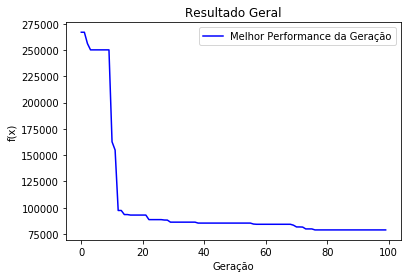

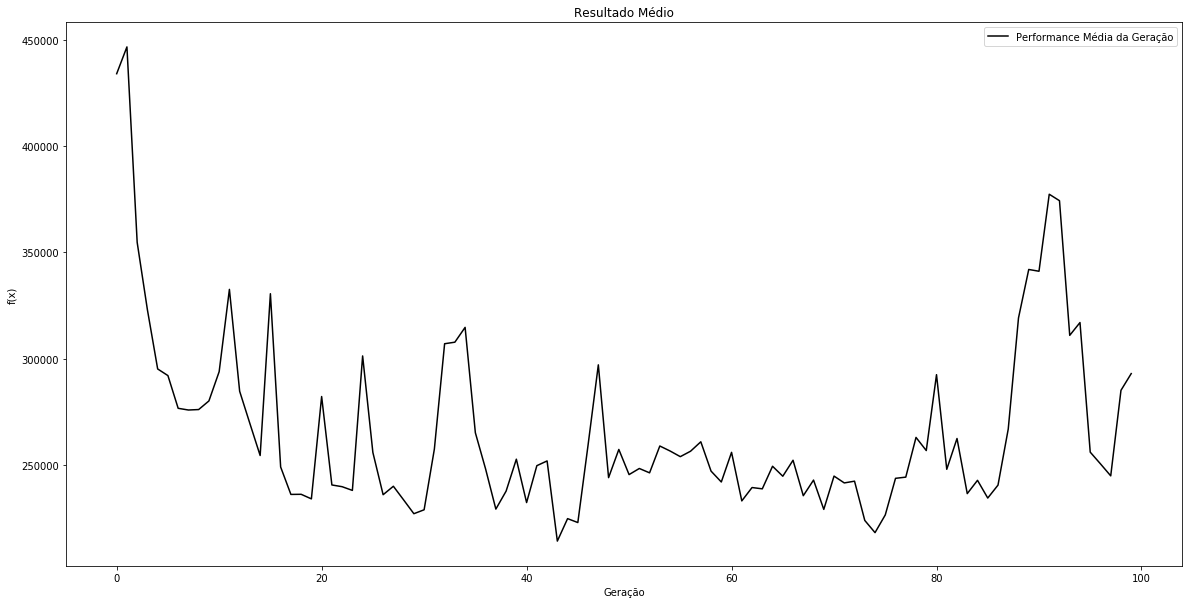

<Figure size 1440x720 with 0 Axes>

In [79]:
%%time

run_genetic_algorithm(df_cali, # Data
                        regressor_1, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, # Regressor 1
                        classifier, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, # Classifier
                        regressor_2, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits, # Regressor 2
                        n_individuos, # Basic info
                        input_função,
                        input_tipo_otimização,
                        input_método_seleção, # Selection
                        probabilidade_cruzamento, # Crossover
                        input_método_cruzamento,
                        input_probabilidade_mutação, # Mutation
                        input_método_mutação,
                        input_probabilidade_elitismo, # Elitism
                        n_max_gen, # Evolution
                        model_name)

In [80]:
best_individual = read_best(local, model_name)

In [228]:
from scipy import stats
from sklearn import metrics

def teste_individuo(individuo, df, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits):

    # Train/Validation/Test Split
    x_train, x_val, x_test, y_train, y_val, y_test = train_valid_test_split(df, .3, .1)

    # Individual decoder
    correlation_threshold, min_correlation, outlier_as_feature, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns, n_uniform_bins, n_quantile_bins, param_grid_1, threshold, clf_param_grid, param_grid_2 = individual_decoder(individuo, x_train, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

    # Removal of correlated features
    x_train, x_val, x_test, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns, uniform_discretizer_columns, quantile_discretizer_columns, yeo_johnson_transformer_columns, box_cox_transformer_columns, min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns = dataframe_slimmer(x_train, x_val, x_test, y_train, correlation_threshold, min_correlation, outlier_as_feature,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            uniform_discretizer_columns, quantile_discretizer_columns,
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns)
    
    # Build Column Transformer (Main Pipeline)
    column_transformer = build_column_transformer(x_train.columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                     uniform_discretizer_columns, quantile_discretizer_columns,
                                                     yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                     min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                     one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                     n_uniform_bins, n_quantile_bins)
    
    try:
        
        # Regressor 1    
        regression_model_1, regressor_1_performance = train_regressor(column_transformer, regressor_1, param_grid_1, x_train, y_train, x_val, y_val)
        
        # Element-Label Association & Threshold Clipper
        y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
        y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))

        y_train_clf = np.where(y_train_clf > threshold, 1, 0)
        y_val_clf = np.where(y_val_clf > threshold, 1, 0)

        ##############################################################################
        x_train_clf, y_train_clf = undersampling(x_train, y_train_clf, seed)
        x_val_clf, y_val_clf = undersampling(x_val, y_val_clf, seed)
        ##############################################################################

        # Classifier
        clf = train_classifier(column_transformer, classifier, clf_param_grid, x_train_clf, y_train_clf, x_val_clf, y_val_clf)

        # Classifier Predictions
        x_train['Outlier'] = clf.predict(x_train)
        x_val['Outlier'] = clf.predict(x_val)

        #########################################################################################
        
        if outlier_as_feature == 1:

            removed_samples = 0

            x_train_cleaned = x_train.copy()
            y_train_cleaned = y_train.copy()
            x_val_cleaned = x_val.copy()
            y_val_cleaned = y_val.copy()
        
        else:
        
        #########################################################################################
        
            # Create Clean Datasets
            removed_samples = len(x_train) # stores previous length for objective function

            # Associate labels for easier filtering
            x_train['Labels'] = y_train
            x_val['Labels'] = y_val

            # Apply filters
            x_train_cleaned = x_train[x_train['Outlier'] == 0].copy()
            x_val_cleaned = x_val[x_val['Outlier'] == 0].copy()

            # Create labels for clean dataset
            y_train_cleaned = x_train_cleaned['Labels']
            y_val_cleaned = x_val_cleaned['Labels']

            # Drop columns
            x_train_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val_cleaned.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            x_train.drop(['Outlier', 'Labels'], axis=1, inplace=True)
            x_val.drop(['Outlier', 'Labels'], axis=1, inplace=True)

            removed_samples = removed_samples - len(x_train_cleaned)

        # Regressor 2
        regression_model_2, regressor_2_performance = train_regressor(column_transformer, regressor_2, param_grid_2, x_train_cleaned, y_train_cleaned, x_val_cleaned, y_val_cleaned)

        # Evaluation of objective function: Regressor 2 Performance + alpha*(number of removed samples)
#         alpha = 0.001 SE MAPE
#         alpha = 0.0001 # Se MAE
        alpha = 10 # Se RMSE (California Housing)
#         system_performance = regressor_2_performance + alpha*(removed_samples)

        # Nova penalização, contendo complexidade do modelo, dada por nº features e quantidade de features com binning
        system_performance = regressor_2_performance + alpha*(removed_samples) + 100*len(x_train.columns) + 100*(len(uniform_discretizer_columns) + len(quantile_discretizer_columns))
    
        #################################################################
        print('-----> r2:', regressor_2_performance)

#         print('-----> r2/MAE:', regressor_2_performance, '-----> r2/MAPE:', np.mean(np.abs((y_val_cleaned - regression_model_2.predict(x_val_cleaned)) / y_val_cleaned)) * 100)

#         print('-----> rmvd:', removed_samples)
        #################################################################

    except:
#         system_performance = np.inf
        system_performance = 1000000 # 100 # 5000
        regression_model_1 = None
        clf = None
        regression_model_2 = None
            
    print('')
    print('Regressor 1 - Entire Data')
    
    x_train.drop('Outlier', axis=1, inplace=True)
    x_val.drop('Outlier', axis=1, inplace=True)
    
    regression_model_1, regressor_1_performance = train_regressor(column_transformer, regressor_1, param_grid_1, x_train, y_train, x_val, y_val)
    
    for pair in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
        
        reg_1_y_pred = regression_model_1.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_1_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print('Regressor 1 - Cleaned Data')
    
    for pair in [(x_train_cleaned.drop('Outlier', axis=1, inplace=False), y_train_cleaned), (x_val_cleaned.drop('Outlier', axis=1, inplace=False), y_val_cleaned)]: #, (x_test, y_test)]:
        reg_1_y_pred = regression_model_1.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_1_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
            
    # Processamento do Test Set
    
    # Performance Clf
    print('')
    print('Classifier')

    # Element-Label Association & Threshold Clipper
    y_train_clf = absolute_percentage_error(y_train, regression_model_1.predict(x_train))
    y_train_clf = np.where(y_train_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_train)   
    fpr_train, tpr_train, roc_thresholds_train = metrics.roc_curve(y_train_clf, y_probas[:,1])
    
    print('AUC Train', metrics.auc(fpr_train, tpr_train))
    
    # Element-Label Association & Threshold Clipper
    y_val_clf = absolute_percentage_error(y_val, regression_model_1.predict(x_val))
    y_val_clf = np.where(y_val_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_val)
    fpr_val, tpr_val, roc_thresholds_val = metrics.roc_curve(y_val_clf, y_probas[:,1])
    
    print('AUC Val', metrics.auc(fpr_val, tpr_val))
    
    # Element-Label Association & Threshold Clipper
    y_test_clf = absolute_percentage_error(y_test, regression_model_1.predict(x_test))
    y_test_clf = np.where(y_test_clf > threshold, 1, 0)
    y_probas = clf.predict_proba(x_test)
    fpr_test, tpr_test, roc_thresholds_test = metrics.roc_curve(y_test_clf, y_probas[:,1])
    
    print('AUC Test', metrics.auc(fpr_test, tpr_test))
    
    plot_roc_curve(fpr_train, tpr_train, fpr_val, tpr_val, fpr_test, tpr_test)
    plt.show()
    
    # Performance Reg 2 ################################################################ LIMPAR DATAFRAME
    
    x_test_clean = x_test.copy()
    x_test_clean['Label'] = y_test.copy()
    x_test_clean['Outlier'] = clf.predict(x_test)
    
    if outlier_as_feature == 0:
    
        x_test_clean = x_test_clean[x_test_clean['Outlier'] == 0]
        y_test_clean = x_test_clean['Label']
        
    else:
        y_test_clean = y_test.copy()
        
#     x_test_clean.drop(['Outlier', 'Label'], axis=1, inplace=True)
    x_test_clean.drop('Label', axis=1, inplace=True)
    
    # Build Column Transformer (Main Pipeline)   
    x_train['Outlier'] = clf.predict(x_train)
    x_val['Outlier'] = clf.predict(x_val)
    x_test['Outlier'] = clf.predict(x_test)
    
    column_transformer = build_column_transformer(x_train.columns, mean_imputer_columns, most_frequent_imputer_columns, constant_positive_imputer_columns, constant_negative_imputer_columns, out_of_distribution_imputer_columns,
                                                     uniform_discretizer_columns, quantile_discretizer_columns,
                                                     yeo_johnson_transformer_columns, box_cox_transformer_columns, 
                                                     min_max_scaler_columns, max_abs_scaler_columns, std_scaler_columns, robust_scaler_columns, 
                                                     one_hot_encoder_columns, frequency_encoder_columns, binary_encoder_columns, hashing_encoder_columns, boolean_encoder_columns,
                                                     n_uniform_bins, n_quantile_bins)
    
    regression_model_2, regressor_2_performance = train_regressor(column_transformer, regressor_2, param_grid_2, x_train_cleaned, y_train_cleaned, x_val_cleaned, y_val_cleaned)

    
    print('')
    print('Regressor 2 - Entire Data')
    for pair in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
        
        reg_2_y_pred = regression_model_2.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_2_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print(compute_confidence_interval(0.95, reg_2_y_pred, y_test))
        
    print('')
    print('Regressor 2 - Cleaned Data')
    for pair in [(x_train_cleaned, y_train_cleaned), (x_val_cleaned, y_val_cleaned), (x_test_clean, y_test_clean)]:
        
        reg_2_y_pred = regression_model_2.predict(pair[0])
        model_performance = mean_absolute_percentage_error(pair[1], reg_2_y_pred)
        print(str(retrieve_name(pair[0]))[2:], model_performance)
        
    print('')
    print(compute_confidence_interval(0.95, reg_2_y_pred, y_test_clean))
    
    # Retorna modelos e datasets
    models = [regression_model_1, clf, regression_model_2]
    datasets = [(x_train, y_train), (x_val, y_val), (x_test, y_test), 
                (x_train_cleaned, y_train_cleaned), (x_val_cleaned, y_val_cleaned), (x_test_clean, y_test_clean)]
    
    return column_transformer, models, datasets

-----> r2: 77038.8101567957

Regressor 1 - Entire Data
train 90085.68357240822
val 126119.91607927361
test 294440.3619729814

Regressor 1 - Cleaned Data
r 90085.68357240822
r 126119.91607927361

Classifier
AUC Train 0.5947680944018641
AUC Val 0.5708051051920479
AUC Test 0.6179949212091697


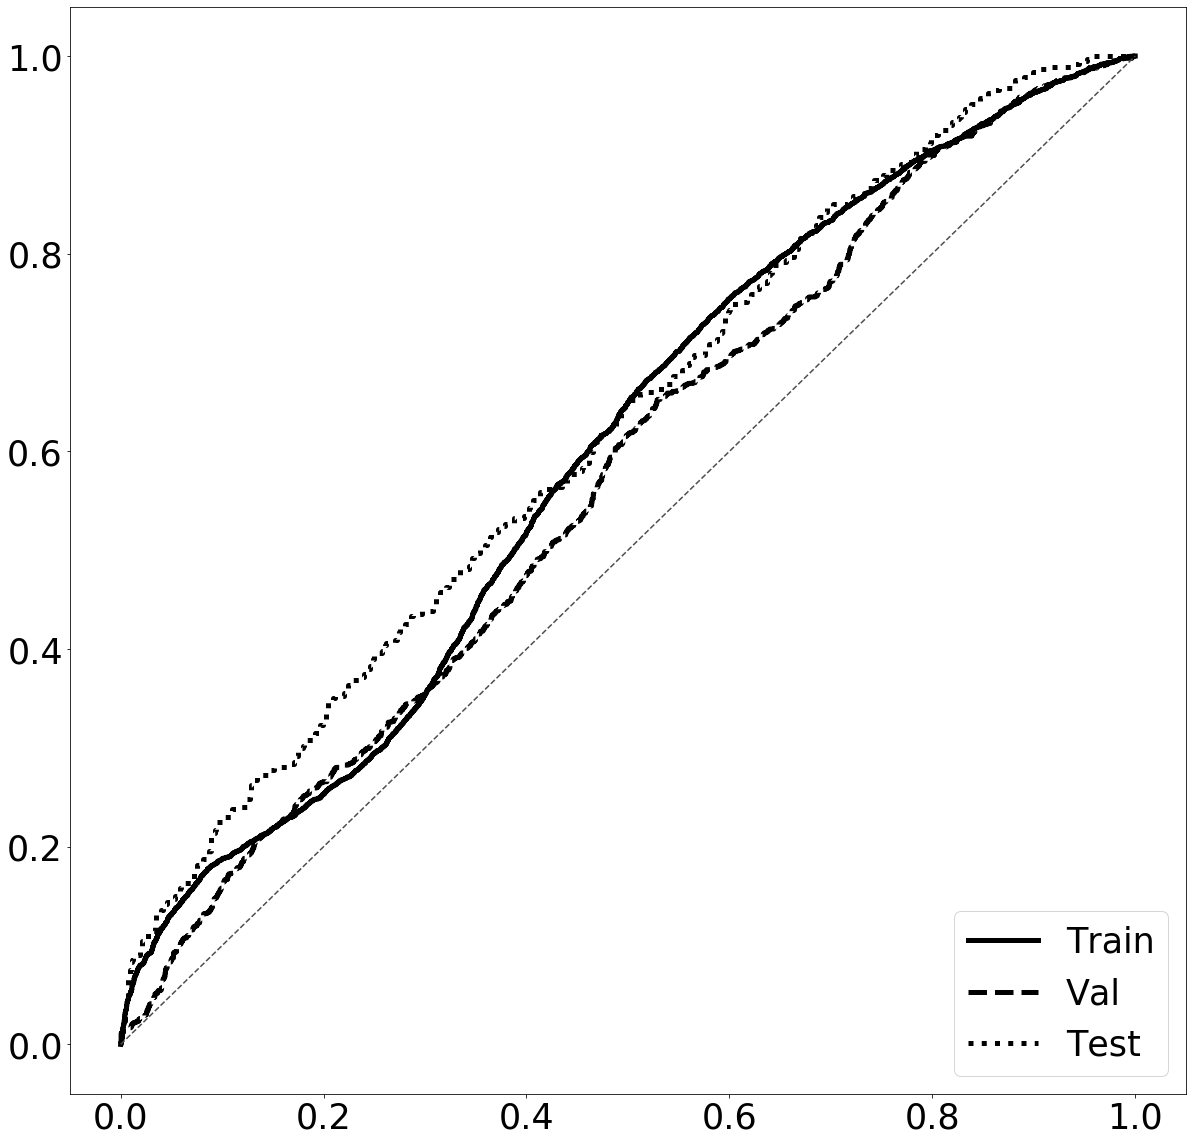


Regressor 2 - Entire Data
train 57020.822375096126
val 75935.38884985413
test 59023.79985175412

(42603.03667031429, 45971.627405427236)

Regressor 2 - Cleaned Data
train_cleaned 55562.296327745215
val_cleaned 77038.8101567957
test_clean 59023.79985175412

(42603.03667031429, 45971.627405427236)
Wall time: 4.93 s


In [229]:
%%time

cali_final_pipeline, cali_mdls, cali_dtsts = teste_individuo(best_individual, df_cali, r1_parameter_types, r1_parameter_ranges, r1_parameter_bits, clf_parameter_types, clf_parameter_ranges, clf_parameter_bits, r2_parameter_types, r2_parameter_ranges, r2_parameter_bits)

# MLP CALI PIPELINE FRAMEWORK

In [85]:
import tensorflow as tf
from tensorflow import keras

In [86]:
tf.config.experimental.list_physical_devices(device_type="GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [87]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [88]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [89]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7448941000302619200
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2206046619
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15337445957732661765
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [251]:
neural_X_train = cali_dtsts[0][0].copy()
neural_y_train = cali_dtsts[0][1].copy()

neural_X_val = cali_dtsts[1][0].copy()
neural_y_val = cali_dtsts[1][1].copy()

neural_X_test = cali_dtsts[2][0].copy()
neural_y_test = cali_dtsts[2][1].copy()

neural_X_train_cln = cali_dtsts[3][0].copy()
neural_y_train_cln = np.array(cali_dtsts[3][1].copy())

neural_X_val_cln = cali_dtsts[4][0].copy()
neural_y_val_cln = np.array(cali_dtsts[4][1].copy())

neural_X_test_cln = cali_dtsts[5][0].copy()
neural_y_test_cln = np.array(cali_dtsts[5][1].copy())

In [217]:
neural_pipeline = cali_final_pipeline

In [189]:
%%time

# A: TREINO DF SUJO, TESTE DF SUJO
cali_a_neural_reg, cali_a_result, cali_a_ci = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, neural_pipeline, seed)

0
Trial 0  - Performance 285532.4708240385
MAPE 99.96895692969817
1
Trial 1  - Performance 137726.0267891546
MAPE 55.67534353096521
2
3
4
5
6
7
Trial 7  - Performance 121272.57260495436
MAPE 48.66102727252128
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Trial 28  - Performance 121053.01923673718
MAPE 48.988267281472176
29

Final Performance on Test Set:
122545.13275888687

Confidence Intervals:
(104544.24482746015, 109683.7223335568)

Parameters:
Number of Hidden Layers: 6
Number of Neurons: 95
Activation Function: elu
Learning Rate: 0.1
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000206F4190B08>
Dropout Ratio: 0.25
Wall time: 30min 2s


In [190]:
cali_a_neural_reg.save('cali_a_neural_reg.h5')

In [191]:
%%time

# B: TREINO DF SUJO, TESTE DF LIMPO
cali_b_neural_reg, cali_b_result, cali_b_ci = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test_cln, neural_y_test_cln, neural_pipeline, seed)

0
Trial 0  - Performance 285532.4708240385
MAPE 99.96895692969817
1
Trial 1  - Performance 137726.0267891546
MAPE 55.67534353096521
2
3
4
5
6
7
Trial 7  - Performance 121193.27278042067
MAPE 48.77495316015739
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Trial 28  - Performance 121053.01923673718
MAPE 48.988267281472176
29

Final Performance on Test Set:
180581.94045327744

Confidence Intervals:
(173498.1084206137, 185779.05934254423)

Parameters:
Number of Hidden Layers: 6
Number of Neurons: 95
Activation Function: elu
Learning Rate: 0.1
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000206F7866708>
Dropout Ratio: 0.25
Wall time: 32min 48s


In [192]:
cali_b_neural_reg.save('cali_b_neural_reg.h5')

In [195]:
%%time

# C: TREINO DF LIMPO, TESTE DF SUJO
cali_c_neural_reg, cali_c_result, cali_c_ci = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test, neural_y_test, neural_pipeline, seed)

0
Trial 0  - Performance 285535.7837510923
MAPE 99.97077870481641
1
Trial 1  - Performance 138996.05038762654
MAPE 54.84784644555675
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Trial 18  - Performance 130666.7064354141
MAPE 43.61394081729896
19
Trial 19  - Performance 124089.96097227106
MAPE 46.15194427311684
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
112399.9438078874

Confidence Intervals:
(94576.80439633137, 99475.53602437081)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 79
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000207169BC9C8>
Dropout Ratio: 0.2
Wall time: 27min 11s


In [196]:
cali_c_neural_reg.save('cali_c_neural_reg.h5')

In [197]:
%%time

# D: TREINO DF LIMPO, TESTE DF LIMPO
cali_d_neural_reg, cali_d_result, cali_d_ci = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test_cln, neural_y_test_cln, neural_pipeline, seed)

0
Trial 0  - Performance 285535.7837510923
MAPE 99.97077870481641
1
Trial 1  - Performance 138996.05038762654
MAPE 54.84784644555675
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Trial 18  - Performance 120312.15533521865
MAPE 50.599400672614934
19
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
188093.6274705607

Confidence Intervals:
(181047.6552956137, 193328.60621754423)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 71
Activation Function: relu
Learning Rate: 1
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002071AB57A48>
Dropout Ratio: 0.2
Wall time: 32min 50s


In [198]:
cali_d_neural_reg.save('cali_d_neural_reg.h5')

# MLP CALI STANDARD PIPELINE

In [199]:
%%time

# A: TREINO DF SUJO, TESTE DF SUJO

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

cali_a_neural_reg_std, cali_a_result_std, cali_a_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, standard_pipeline, seed)

0
Trial 0  - Performance 285564.9971939754
MAPE 99.98684518382214
1
Trial 1  - Performance 148270.9564697047
MAPE 54.56520271863692
2
3
4
5
6
Trial 6  - Performance 123645.51653963113
MAPE 46.43604891123639
7
8
9
10
11
12
13
14
15
16
17
18
19
Trial 19  - Performance 121065.15018830916
MAPE 48.96913364248381
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
122481.47195165645

Confidence Intervals:
(104481.72998227933, 109619.7201690524)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 79
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002072D65F308>
Dropout Ratio: 0.2
Wall time: 32min 14s


In [200]:
cali_a_neural_reg_std.save('cali_a_neural_reg_std.h5')

In [201]:
%%time

# B: TREINO DF SUJO, TESTE DF LIMPO

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

cali_b_neural_reg_std, cali_b_result_std, cali_b_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

0
Trial 0  - Performance 285564.9971939754
MAPE 99.98684518382214
1
Trial 1  - Performance 148270.9564697047
MAPE 54.56520271863692
2
3
4
5
6
Trial 6  - Performance 123645.51653963113
MAPE 46.43604891123639
7
8
9
10
11
12
13
14
15
16
17
18
Trial 18  - Performance 123409.74404662398
MAPE 46.59853087971354
19
Trial 19  - Performance 121065.15018830916
MAPE 48.96913364248381
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
180488.68045519016

Confidence Intervals:
(173404.3584206137, 185685.30934254423)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 79
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002073A6A6BC8>
Dropout Ratio: 0.2
Wall time: 28min 39s


In [202]:
cali_b_neural_reg_std.save('cali_b_neural_reg_std.h5')

In [203]:
%%time

# C: TREINO DF LIMPO, TESTE DF SUJO

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

cali_c_neural_reg_std, cali_c_result_std, cali_c_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test, neural_y_test, standard_pipeline, seed)

0
Trial 0  - Performance 285566.04378111934
MAPE 99.98742072645057
1
Trial 1  - Performance 147851.2735732169
MAPE 53.92502710183318
2
3
4
5
Trial 5  - Performance 146664.1578927542
MAPE 49.30466928349194
6
Trial 6  - Performance 121182.66696386477
MAPE 48.790523983518405
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
121884.95982103603

Confidence Intervals:
(103895.17744521373, 109019.32694340612)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 80
Activation Function: elu
Learning Rate: 1
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000207320E9A08>
Dropout Ratio: 0.2
Wall time: 31min 36s


In [204]:
cali_c_neural_reg_std.save('cali_c_neural_reg_std.h5')

In [206]:
%%time

# D: TREINO DF LIMPO, TESTE DF LIMPO

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

cali_d_neural_reg_std, cali_d_result_std, cali_d_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

0
Trial 0  - Performance 285566.04378111934
MAPE 99.98742072645057
1
Trial 1  - Performance 147851.2735732169
MAPE 53.92502710183318
2
3
4
5
Trial 5  - Performance 146664.1578927542
MAPE 49.30466928349194
6
Trial 6  - Performance 121182.66696386477
MAPE 48.790523983518405
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
179612.06141098085

Confidence Intervals:
(172523.1084206137, 184804.05934254423)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 80
Activation Function: elu
Learning Rate: 1
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000020746091248>
Dropout Ratio: 0.2
Wall time: 30min 45s


In [207]:
cali_d_neural_reg_std.save('cali_d_neural_reg_std.h5')

# MLP STD PIPELINE SEM OUTLIER LABEL

In [243]:
%%time

# A: TREINO DF SUJO, TESTE DF SUJO

try:
    for dataset in [neural_X_train, neural_X_val, neural_X_test]:
        dataset.drop('Outlier', axis=1, inplace=True)
except:
    pass

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

no_dummy_cali_a_neural_reg_std, no_dummy_cali_a_result_std, no_dummy_cali_a_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, standard_pipeline, seed)

0
Trial 0  - Performance 285575.32508405886
MAPE 99.99252471170324
1
Trial 1  - Performance 155201.6539914907
MAPE 46.926643467324745
2
Trial 2  - Performance 148568.14477320097
MAPE 49.324897103294575
3
4
5
6
Trial 6  - Performance 146305.48797791378
MAPE 41.76547502316323
7
Trial 7  - Performance 131347.30658291528
MAPE 43.7142343012456
8
9
10
11
12
13
14
15
16
17
18
19
Trial 19  - Performance 127949.01479562656
MAPE 44.62918849142052
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
105868.78661057224

Confidence Intervals:
(88218.39326804005, 92946.09220659769)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 20
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000020773C289C8>
Dropout Ratio: 0.4
Wall time: 20min 59s


In [244]:
no_dummy_cali_a_neural_reg_std.save('no_dummy_cali_a_neural_reg_std.h5')

In [245]:
%%time

# B: TREINO DF SUJO, TESTE DF LIMPO

try:
    for dataset in [neural_X_train, neural_X_val, neural_X_test_cln]:
        dataset.drop('Outlier', axis=1, inplace=True)
except:
    pass

numerical_features = list(neural_X_train.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

no_dummy_cali_b_neural_reg_std, no_dummy_cali_b_result_std, no_dummy_cali_b_ci_std = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

ValueError: X has 12 features, but ColumnTransformer is expecting 11 features as input.

In [246]:
no_dummy_cali_b_neural_reg_std.save('no_dummy_cali_b_neural_reg_std.h5')

NameError: name 'no_dummy_cali_b_neural_reg_std' is not defined

In [247]:
%%time

# C: TREINO DF LIMPO, TESTE DF SUJO

try:
    for dataset in [neural_X_train_cln, neural_X_val_cln, neural_X_test]:
        dataset.drop('Outlier', axis=1, inplace=True)
except:
    pass

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

no_dummy_cali_c_neural_reg_std, no_dummy_cali_c_result_std, no_dummy_cali_c_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test, neural_y_test, standard_pipeline, seed)

0
Trial 0  - Performance 285575.32508405886
MAPE 99.99252471170324
1
Trial 1  - Performance 155201.6539914907
MAPE 46.926643467324745
2
Trial 2  - Performance 148568.14477320097
MAPE 49.324897103294575
3
4
5
6
Trial 6  - Performance 146305.48797791378
MAPE 41.76547502316323
7
Trial 7  - Performance 131347.30658291528
MAPE 43.7142343012456
8
9
10
11
12
13
14
15
16
17
18
19
Trial 19  - Performance 127949.01479562656
MAPE 44.62918849142052
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
105868.78661057224

Confidence Intervals:
(88218.39326804005, 92946.09220659769)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 20
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000002076618EA08>
Dropout Ratio: 0.4
Wall time: 21min 25s


In [248]:
no_dummy_cali_c_neural_reg_std.save('no_dummy_cali_c_neural_reg_std.h5')

In [249]:
%%time

# D: TREINO DF LIMPO, TESTE DF LIMPO

try:
    for dataset in [neural_X_train_cln, neural_X_val_cln, neural_X_test_cln]:
        dataset.drop('Outlier', axis=1, inplace=True)
except:
    pass

numerical_features = list(neural_X_train_cln.select_dtypes(include=[np.number]).columns)
categorical_features = list(neural_X_train_cln.select_dtypes(exclude=[np.number]).columns)

mean_imputer = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))
std_scaler = make_pipeline(StandardScaler())

numerical_pipeline = Pipeline([('mean_imputer', mean_imputer), ('std_scaler', std_scaler)])
one_hot = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

standard_pipeline = ColumnTransformer(transformers=[
                                ('numerical_pipeline', numerical_pipeline, numerical_features),
                                ('one_hot', one_hot, categorical_features)
                                ], remainder='passthrough')

no_dummy_cali_d_neural_reg_std, no_dummy_cali_d_result_std, no_dummy_cali_d_ci_std = mlp_rs(neural_X_train_cln, neural_y_train_cln, neural_X_val_cln, neural_y_val_cln, neural_X_test_cln, neural_y_test_cln, standard_pipeline, seed)

ValueError: X has 12 features, but ColumnTransformer is expecting 11 features as input.

In [250]:
no_dummy_cali_d_neural_reg_std.save('no_dummy_cali_d_neural_reg_std.h5')

NameError: name 'no_dummy_cali_d_neural_reg_std' is not defined

# MLP CUSTOM PIPELINE SEM OUTLIER LABEL

In [267]:
neural_X_train = cali_dtsts[0][0].copy()
neural_y_train = cali_dtsts[0][1].copy()

neural_X_val = cali_dtsts[1][0].copy()
neural_y_val = cali_dtsts[1][1].copy()

neural_X_test = cali_dtsts[2][0].copy()
neural_y_test = cali_dtsts[2][1].copy()

neural_X_train_cln = cali_dtsts[3][0].copy()
neural_y_train_cln = np.array(cali_dtsts[3][1].copy())

neural_X_val_cln = cali_dtsts[4][0].copy()
neural_y_val_cln = np.array(cali_dtsts[4][1].copy())

neural_X_test_cln = cali_dtsts[5][0].copy()
neural_y_test_cln = np.array(cali_dtsts[5][1].copy())

In [268]:
neural_pipeline = cali_final_pipeline

In [269]:
%%time

try:
    for dataset in [neural_X_train, neural_X_val, neural_X_test]:
        dataset['Outlier'] = 0
except:
    pass


custom_pipe_no_dummy_cali_neural_reg, custom_pipe_no_dummy_cali_result, custom_pipe_no_dummy_cali_ci = mlp_rs(neural_X_train, neural_y_train, neural_X_val, neural_y_val, neural_X_test, neural_y_test, neural_pipeline, seed)

0
Trial 0  - Performance 285544.8744772542
MAPE 99.97577792722197
1
Trial 1  - Performance 139973.17977818623
MAPE 57.8341753577158
2
3
4
5
6
7
8
9
10
Trial 10  - Performance 137798.27302513557
MAPE 53.6399651310953
11
12
13
14
15
16
17
18
Trial 18  - Performance 130948.05940180163
MAPE 43.54218530904211
19
Trial 19  - Performance 129783.40172779252
MAPE 43.85021911353138
20
21
22
23
24
25
26
27
28
29

Final Performance on Test Set:
102669.81443991029

Confidence Intervals:
(85094.81820704887, 89743.20879052981)

Parameters:
Number of Hidden Layers: 5
Number of Neurons: 79
Activation Function: elu
Learning Rate: 0.3
Optimizer: <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000207971D3508>
Dropout Ratio: 0.2
Wall time: 23min 35s


In [270]:
custom_pipe_no_dummy_cali_neural_reg.save('custom_pipe_no_dummy_cali_neural_reg.h5')

# PLOTS

# GITHUB ANONIMO 

In [ ]:
import plotly.express as px

colors = ['#37AA9C', '#333F44', '#37AA9C', '#333F44']

performances = [30.523470620992025, 28.847388589172812, 24.09894654626095, 22.23736070808674]

fig = px.bar(performances, x=models, y=performances, text=performances)

fig.update_traces(texttemplate='%{text:.5s}', textposition='outside')

fig.update_traces(marker_color=colors)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig.show()

In [ ]:
import plotly.express as px

In [ ]:
max_ = 1000

# Group data together
hist_data = [np.where(plty_train > max_, max_, plty_train), np.where(plty_val > max_, max_, plty_val), np.where(plty_test > max_, max_, plty_test)]

group_labels = ['Train', 'Validation', 'Test']
colors = ['#333F44', '#37AA9C', '#94F3E4']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=.75
))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    font=dict(size=20))
fig.show()

In [ ]:
# Group data together
hist_data = [np.log1p(plty_train), np.log1p(plty_val), np.log1p(plty_test)]

max_ = np.log1p(50)

hist_data = [np.where(np.log1p(plty_train) > max_, max_, np.log1p(plty_train)), 
             np.where(np.log1p(plty_val) > max_, max_, np.log1p(plty_val)), 
             np.where(np.log1p(plty_test) > max_, max_, np.log1p(plty_test))]



group_labels = ['Transformed Train', 'Transformed Validation', 'Transformed Test']
colors = ['#333F44', '#37AA9C', '#94F3E4']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=.75
))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    font=dict(size=20))

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=list(range(0, 100)), y=best_genetic_values))
fig['layout']['yaxis']['autorange'] = "reversed"

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=.75
))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    font=dict(size=15),
    yaxis_range=[25, 23])


fig.update_layout( shapes=[
# unfilled rectange
go.layout.Shape(
type="rect",
xref="paper",
yref="paper",
x0=0,
y0=-0.1,
x1=1.05,
y1=1,
line={'width': 1, 'color': 'black'})])


fig.update_yaxes(ticks="outside")
fig.update_layout(yaxis=dict(range=[23, 25]))

fig.show()

In [ ]:
models = ['SGD Linear Regression', 'XGBoost Regressor', 'Extra Trees Regressor', 'Proposed Method - RANSAC', 'Proposed Method - XGBoost']
models = ['A', 'B', 'C', 'D', 'E']

In [ ]:
performances = [39.31977565543443, 29.225615254423737, 28.85562, 36.19285117658214, 22.23736070808674]

In [ ]:
import plotly.express as px

colors = ['#37AA9C', '#37AA9C', '#37AA9C', '#333F44', '#333F44']

fig = px.bar(performances, x=models, y=performances, text=performances)

fig.update_traces(texttemplate='%{text:.5s}', textposition='outside')

fig.update_traces(marker_color=colors)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig.show()

In [ ]:
neural_y_train = dtsts[0][1].copy()
neural_y_val = dtsts[1][1].copy()
neural_y_test = dtsts[2][1].copy()


# neural_y_train_cln = np.array(dtsts[3][1].copy())
# neural_y_val_cln = np.array(dtsts[4][1].copy())
# neural_y_test_cln = np.array(dtsts[5][1].copy())

In [ ]:
def auxiliary_train_valid_test_split(df, validation_rate, test_rate):
    
    # Create a copy of the dataframe
    data = df.copy()

#     data['Preço_Unitário'] = data['Preço_Unitário']/data['Custo_Unitário_Final_Produto'] ######################## NOVO RÓTULO
    
    split_ratio = validation_rate # .3 Considering the entire dataset
    test_ratio = test_rate # .1 Considering the entire dataset

    train, val = train_test_split(data, shuffle=False, test_size=split_ratio)
    val, test = train_test_split(val, shuffle=False, test_size=test_ratio/split_ratio)

    x_train, x_val, x_test = train.drop(['Custo_Unitário_Final_Produto'], axis=1), val.drop(['Custo_Unitário_Final_Produto'], axis=1), test.drop(['Custo_Unitário_Final_Produto'], axis=1) 
    y_train, y_val, y_test = train['Custo_Unitário_Final_Produto'].values, val['Custo_Unitário_Final_Produto'].values, test['Custo_Unitário_Final_Produto'].values

    return y_train, y_val, y_test

In [ ]:
y_train, y_val, y_test = auxiliary_train_valid_test_split(df, .3, .1)

In [ ]:
plt.hist(y_train, density=False, bins=25, range=[0, 600], log=True, linewidth=3, edgecolor='white', color='black')
plt.rcParams['axes.linewidth'] = 3
plt.rcParams.update({'font.size': 60})
plt.ylabel('Count')
plt.xlabel('Train Data - Sales Value');
plt.show()

In [ ]:
plt.hist(np.log1p(neural_y_val), density=False, bins=25, range=[0, 4], linewidth=3, edgecolor='white')#, color='green')
plt.rcParams['axes.linewidth'] = 3
plt.rcParams.update({'font.size': 60})
plt.ylabel('Count')
plt.xlabel('Validation Data - Transformed Markup Value');
plt.show()